In [1]:
import pandas as pd
import numpy as np

from scipy import stats, odr

from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

# Reading Cleaned Data

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
# Data types
df.dtypes

Sex           object
Event         object
Age          float64
Tested        object
Squat        float64
Bench        float64
Dead         float64
Total        float64
Weight        object
AgeGroup    category
dtype: object

# Removing Drug Tested Competitions

Data Exploration and Statistical Testing will be first performed separately and the results will be compared at the end.


In [4]:
df = df[df['Tested']=='No'].reset_index(drop = True)

# Stratifying Strength Data

Total = Weight of all three lifts combined (must have three at one competition)

Deadlift = Weight of maximum deadlift

Bench Press = Weight of maximum bench press

Squat = Weight of maximum squat

In [5]:
total = df[(df['Event']=='SBD')&\
          (df['Total'].notnull())&(df['Total']>0)].reset_index(drop = True)[['Sex','Age','Tested','Total','Weight','AgeGroup']].copy()

dead = df[(df['Dead'].notnull())&\
         (df['Dead']>0)].reset_index(drop = True)[['Sex','Age','Tested','Dead','Weight','AgeGroup']].copy()

bench = df[(df['Bench'].notnull())&\
          (df['Bench']>0)].reset_index(drop = True)[['Sex','Age','Tested','Bench','Weight','AgeGroup']].copy()

squat = df[(df['Squat'].notnull())&\
          (df['Squat']>0)].reset_index(drop = True)[['Sex','Age','Tested','Squat','Weight','AgeGroup']].copy()

# Visualizations - Age, Weight, Strength

In [6]:
def quadrant(total,bench,squat,dead,sex,plot):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)
    
    if plot == 'Scatter':
        sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', color='steelblue', ax=axs[0, 0])
        sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()
    elif plot == 'Box':
        sns.boxplot(data=total[total['Sex'] == sex].copy(), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
        sns.boxplot(data=bench[bench['Sex'] == sex].copy(), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.boxplot(data=squat[squat['Sex'] == sex].copy(), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.boxplot(data=dead[dead['Sex'] == sex].copy(), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()

Sex = M

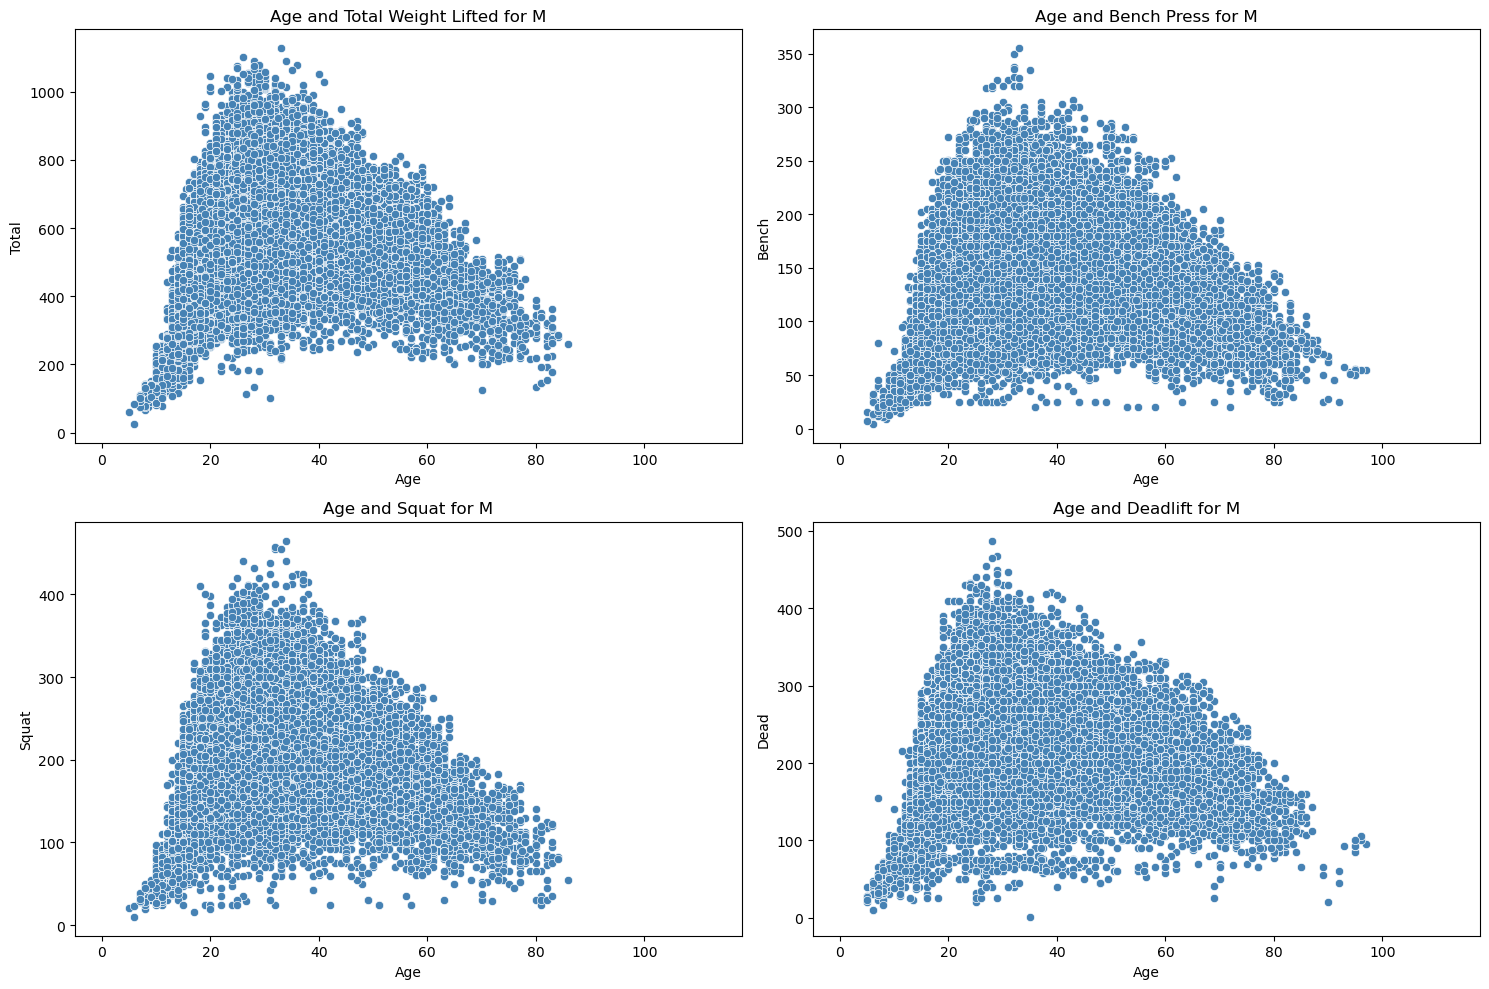

In [7]:
quadrant(total,bench,squat,dead,'M','Scatter')

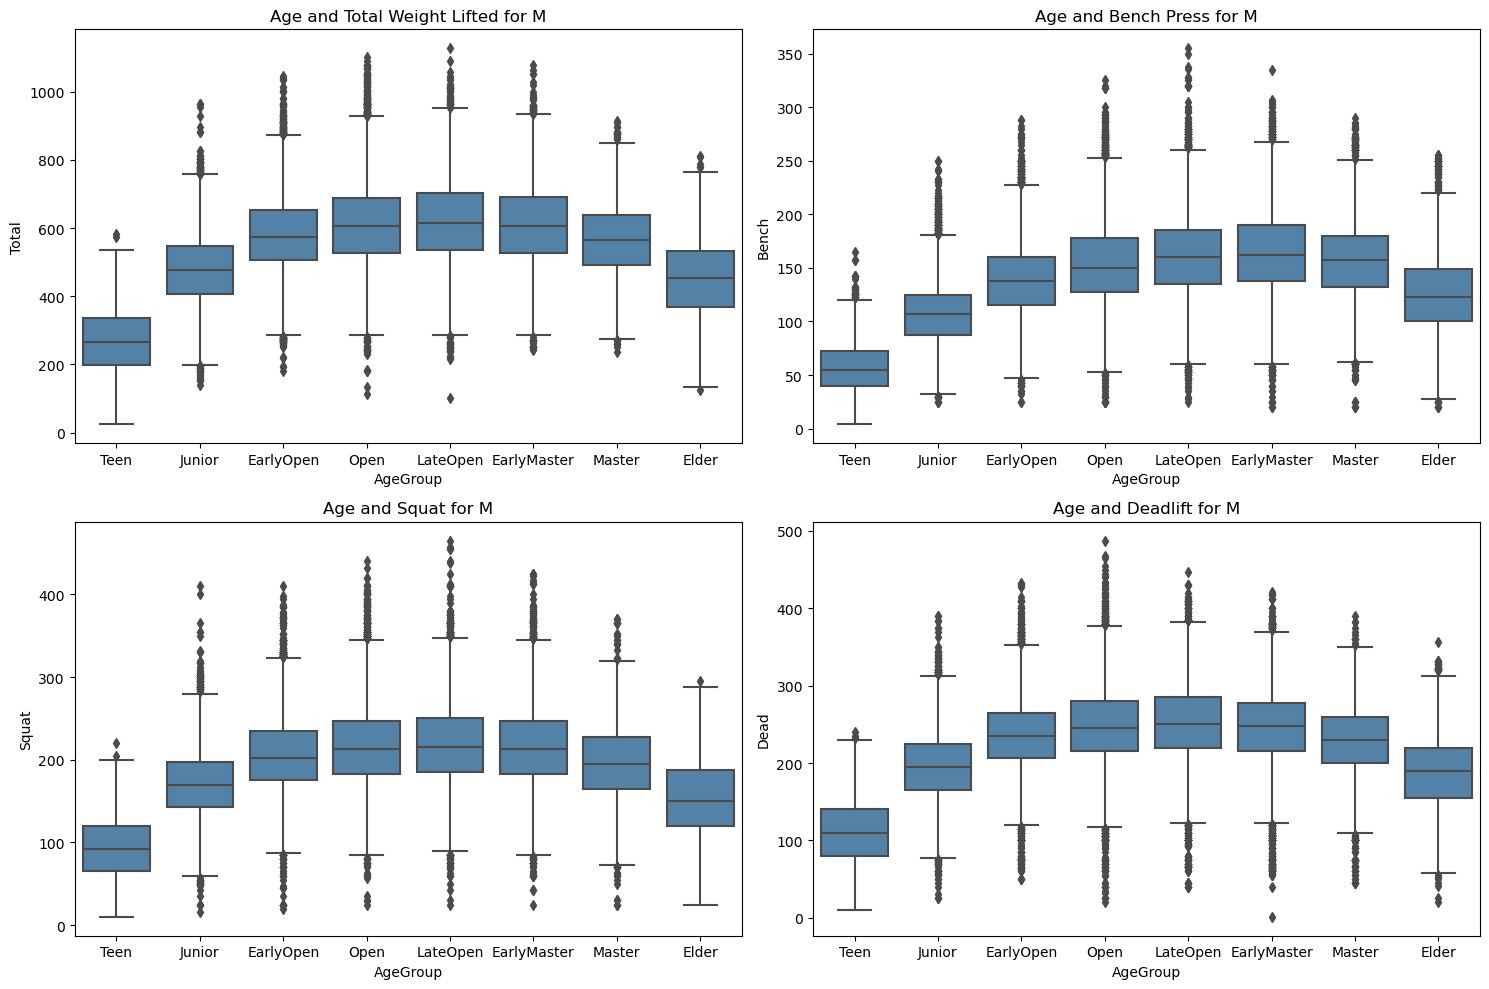

In [8]:
quadrant(total,bench,squat,dead,'M','Box')

Sex = F

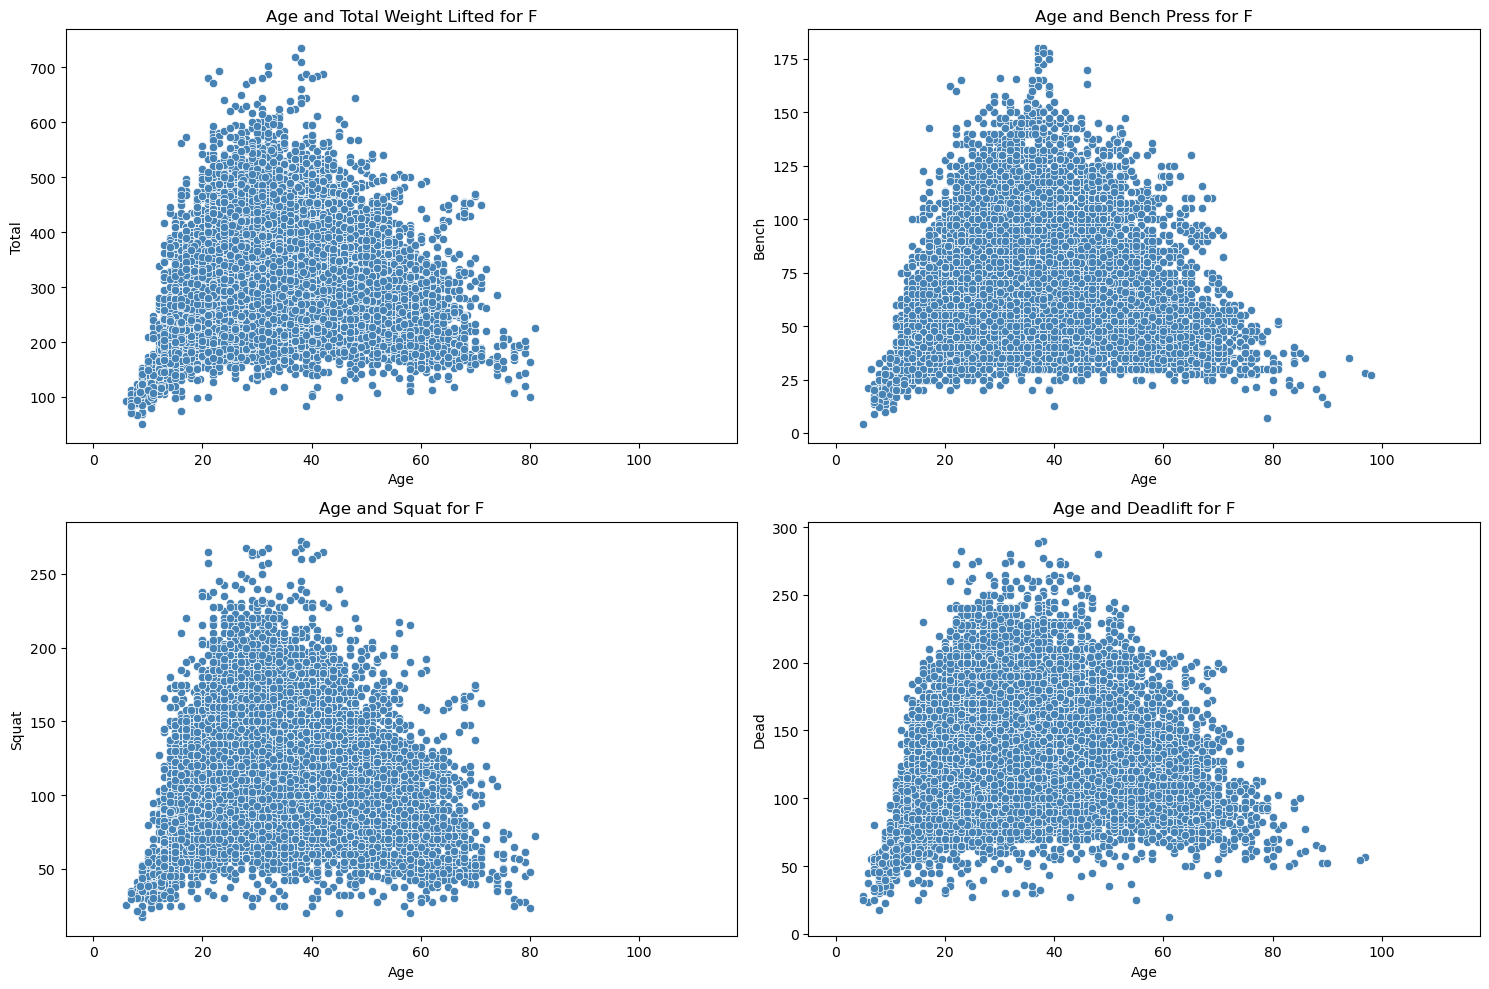

In [9]:
# Female
quadrant(total,bench,squat,dead,'F','Scatter')

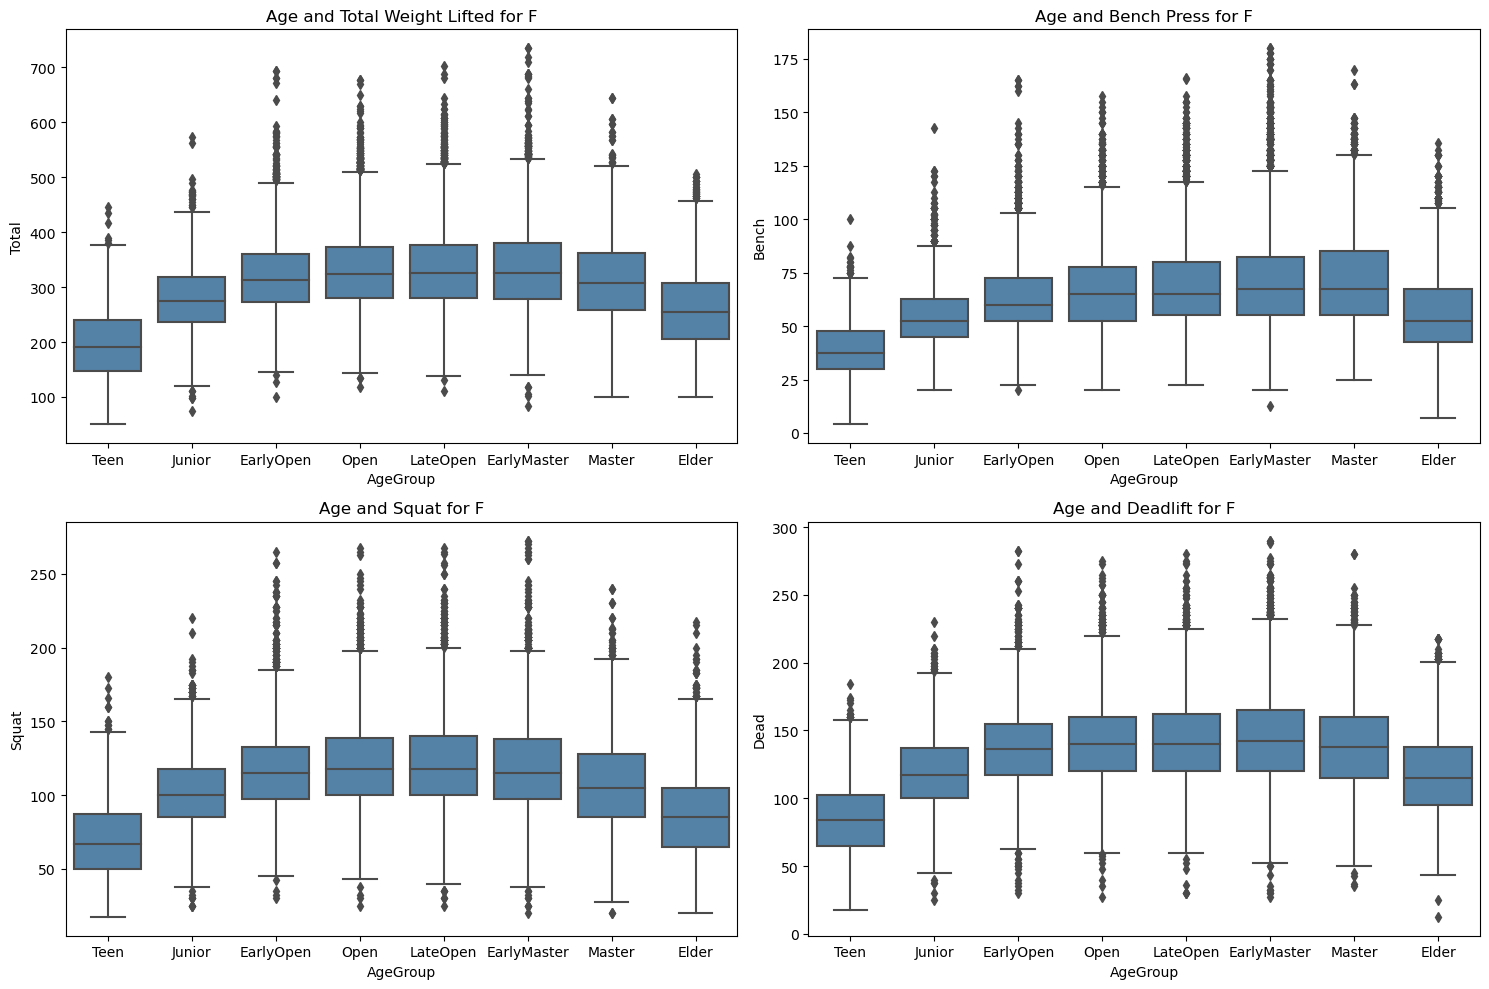

In [10]:
quadrant(total,bench,squat,dead,'F','Box')

Take a random sample for each age group

In [11]:
age_groups = df['AgeGroup'].unique()

def sample(total, n):
    dfs = pd.DataFrame()
    for x in range(len(age_groups)):
        a = total[total['AgeGroup']==age_groups[x]].copy()
        aa = a.sample(n = 500).copy()
        dfs = pd.concat([dfs,aa], axis = 0, ignore_index = True)
    return dfs

Sex = M

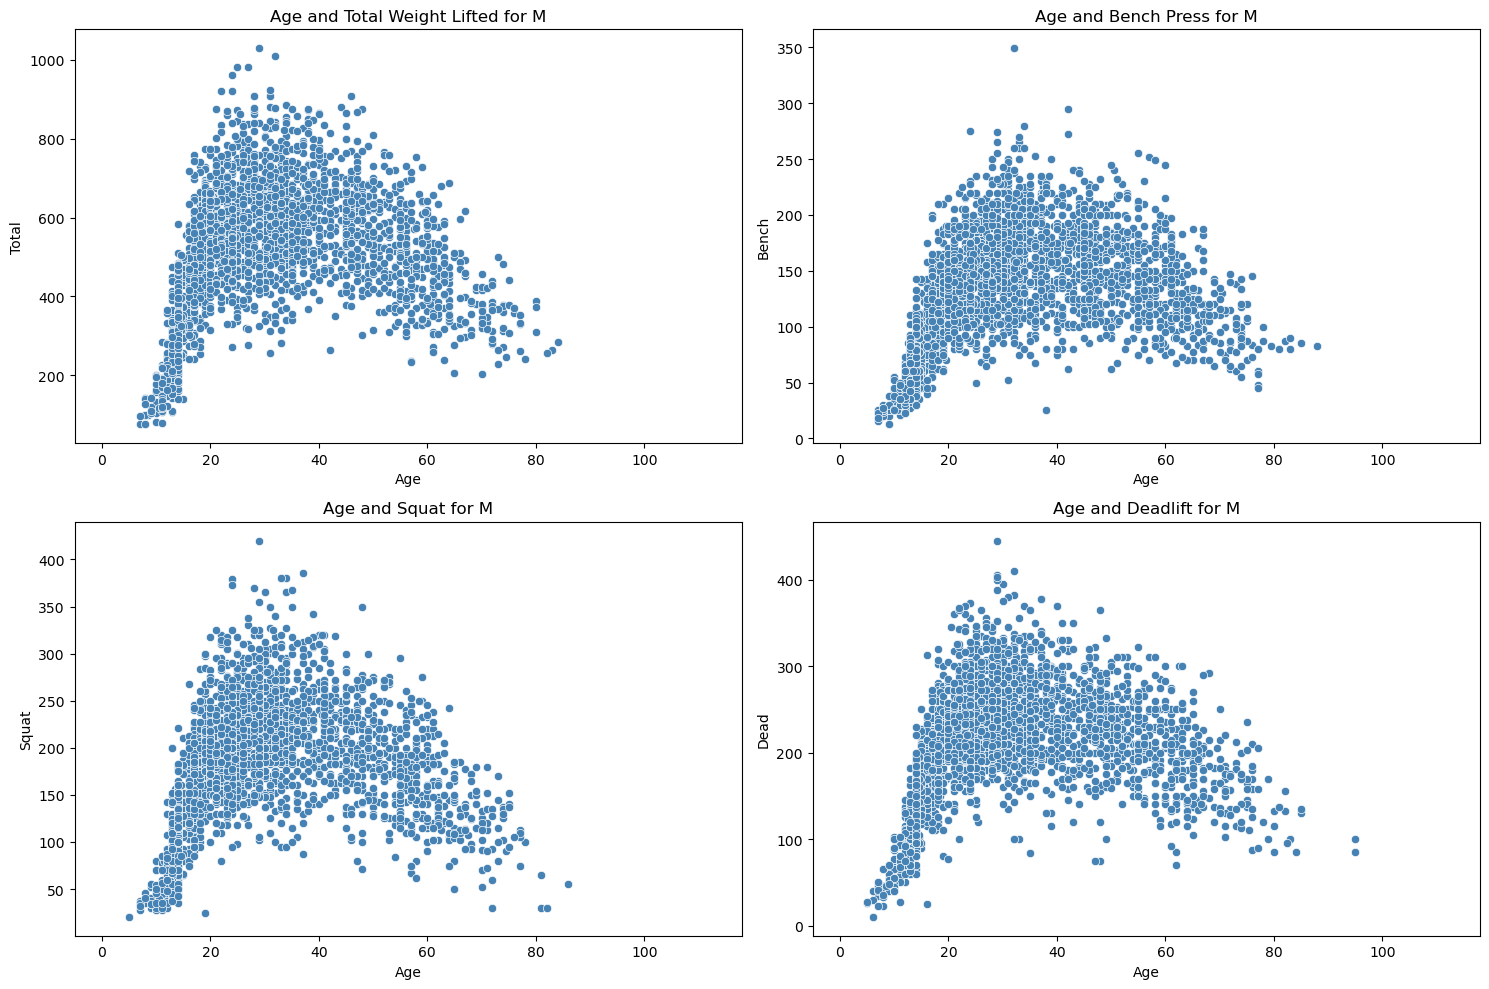

In [12]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Scatter')

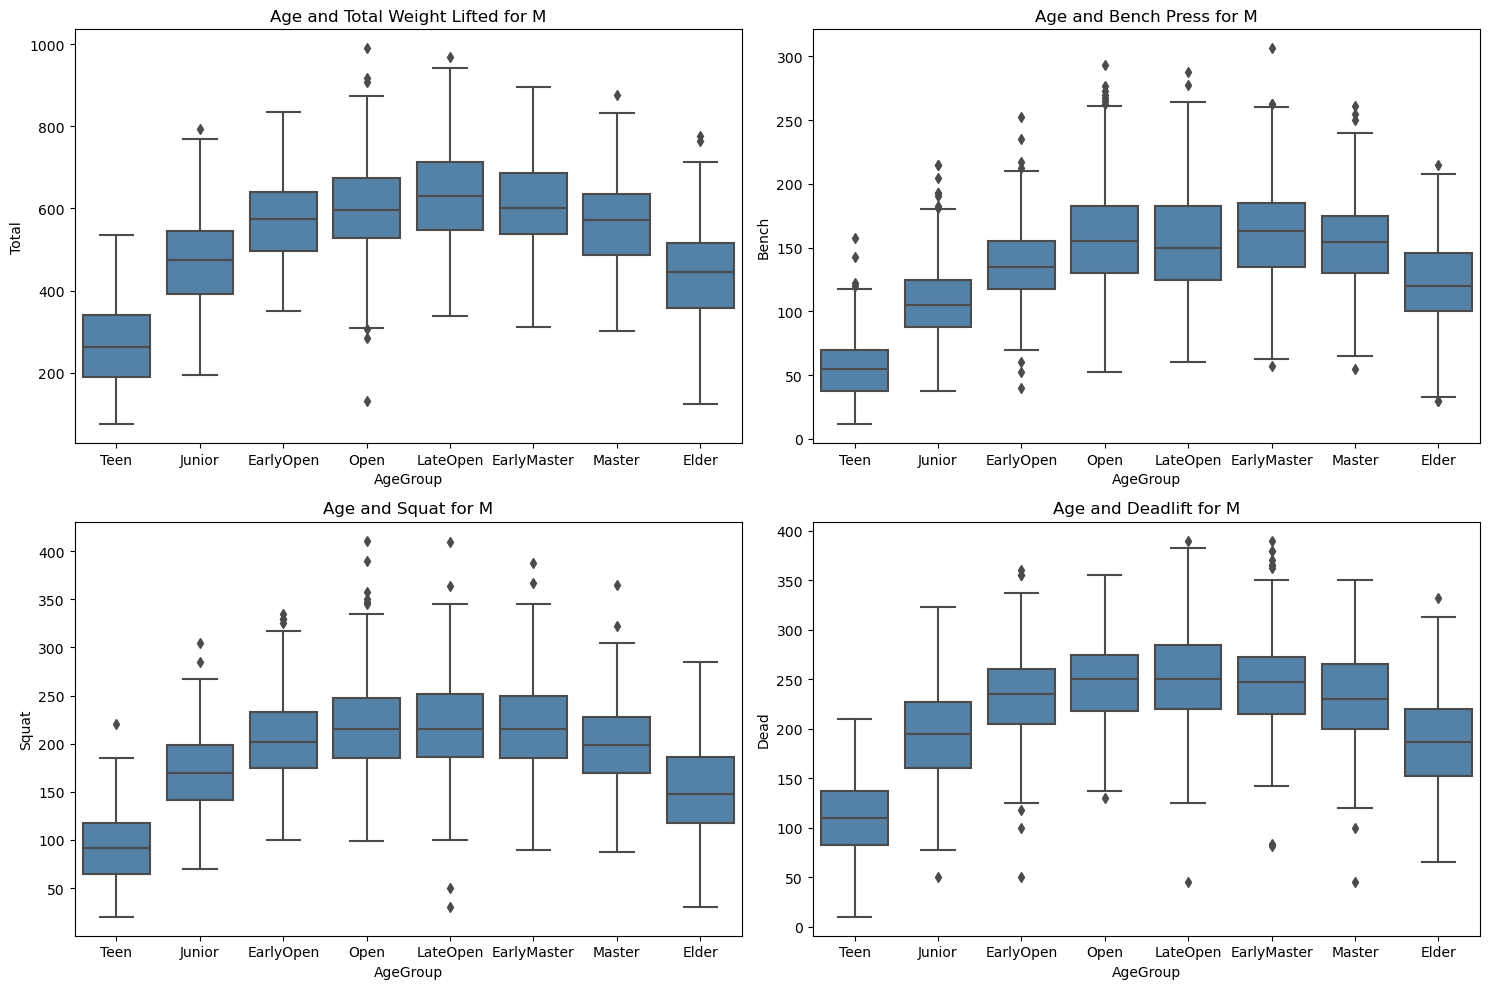

In [13]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Box')

Sex = F

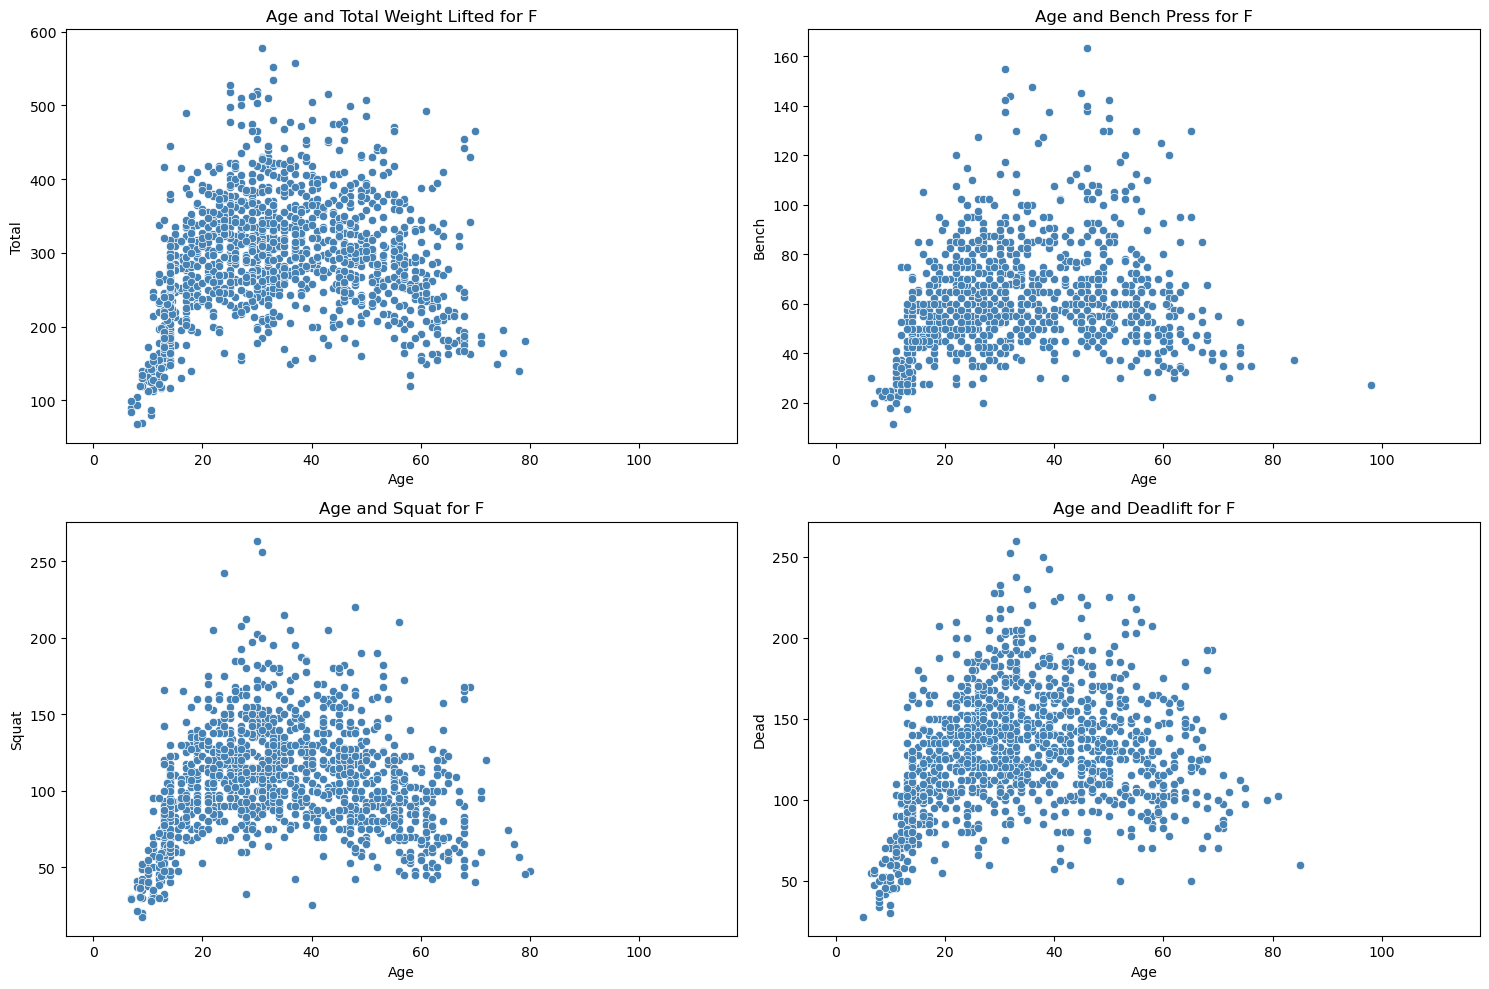

In [14]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Scatter')

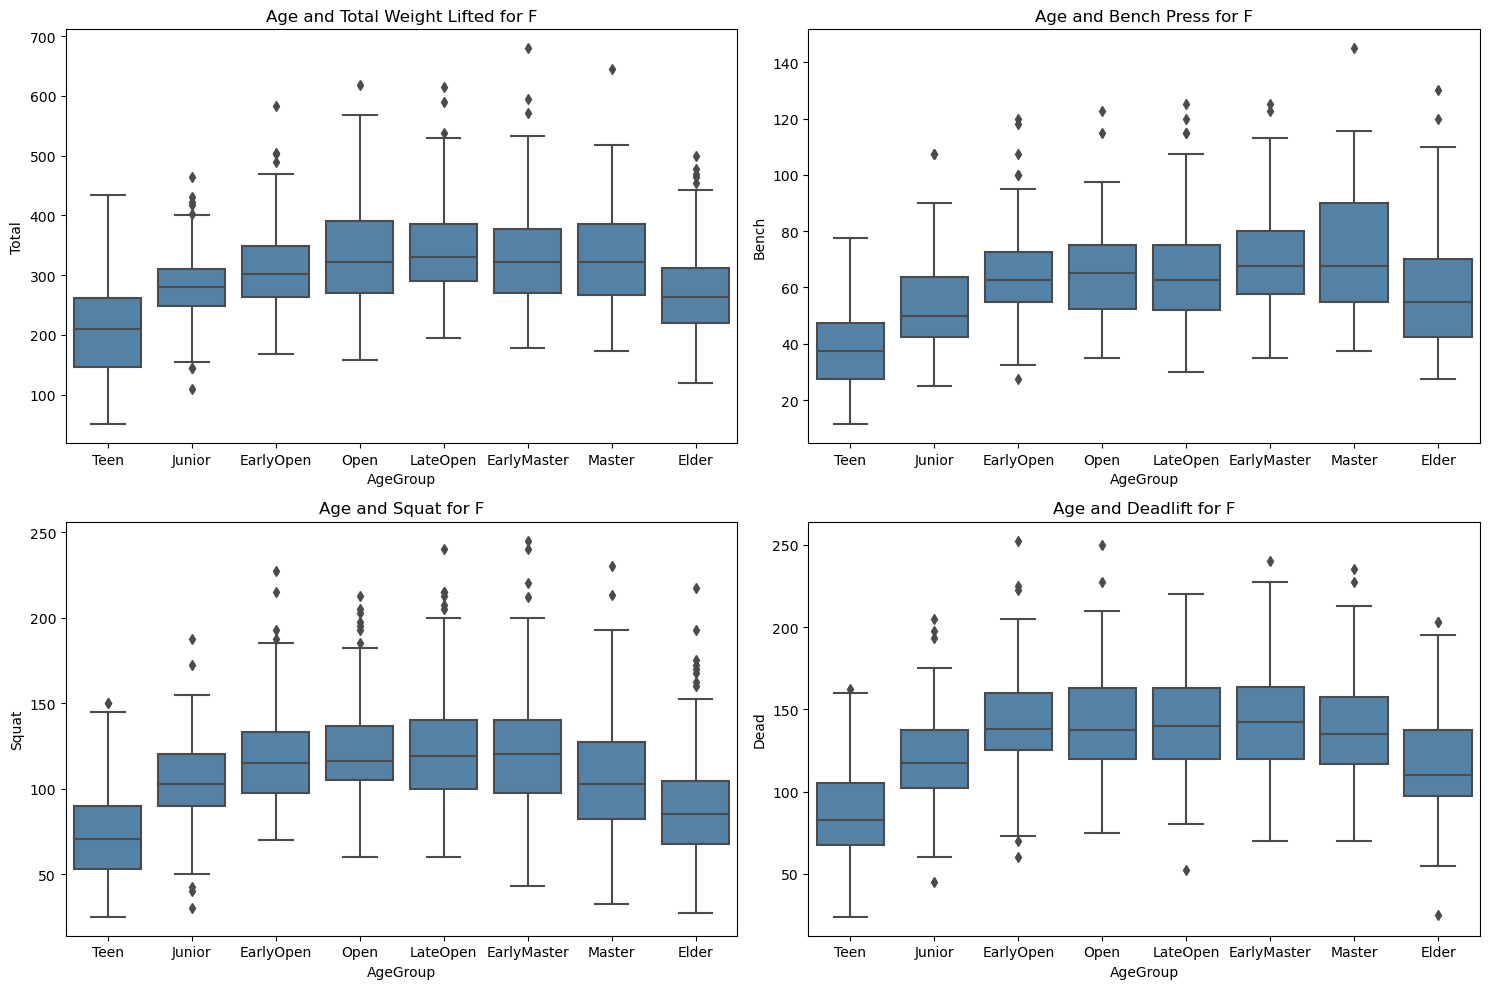

In [15]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Box')

Random Selected Sample Scatter Plot with Hue

In [16]:
def quadrant_hue(total,bench,squat,dead,sex,hue,group):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
    if group == 'Lighter':
        total = total[total['Weight'].isin(['Light','Middle'])]
        dead = dead[dead['Weight'].isin(['Light','Middle'])]
        squat = squat[squat['Weight'].isin(['Light','Middle'])]
        bench = bench[bench['Weight'].isin(['Light','Middle'])]
    elif group == 'Heavier':
        total = total[total['Weight'].isin(['Heavy','SuperHeavy'])]
        dead = dead[dead['Weight'].isin(['Heavy','SuperHeavy'])]
        squat = squat[squat['Weight'].isin(['Heavy','SuperHeavy'])]
        bench = bench[bench['Weight'].isin(['Heavy','SuperHeavy'])]
    
    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)

    hue_order = total[hue].unique()

    palette = sns.color_palette('Accent', n_colors=len(hue_order))

    sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', ax=axs[0, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', ax=axs[0, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', ax=axs[1, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', ax=axs[1, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    plt.tight_layout()

Sex = M

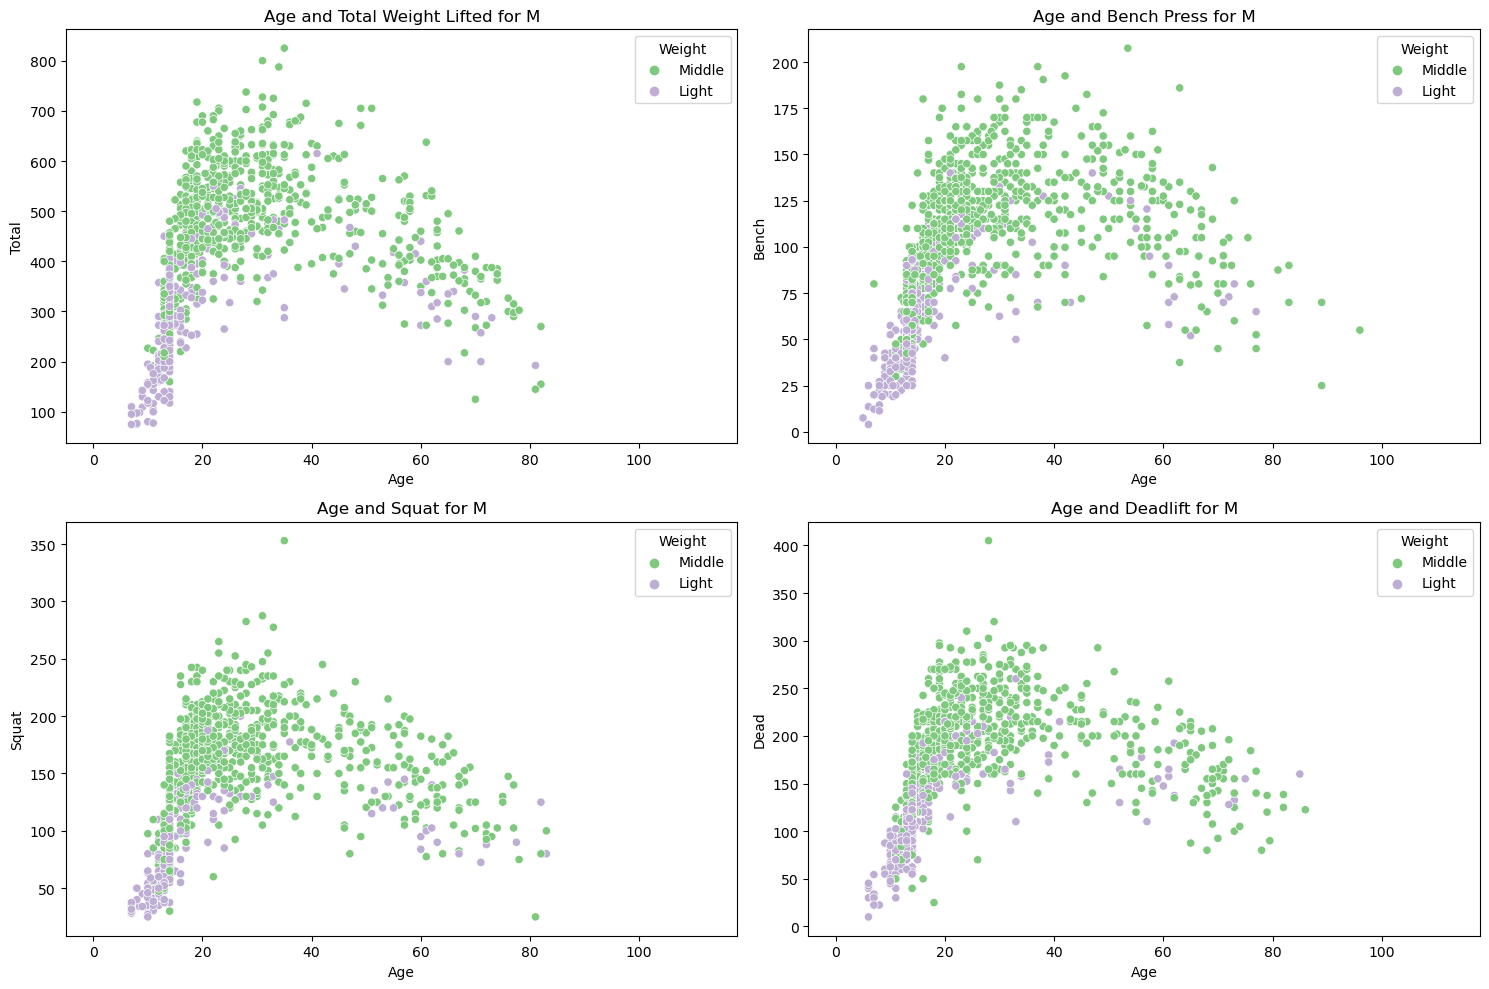

In [17]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Lighter')

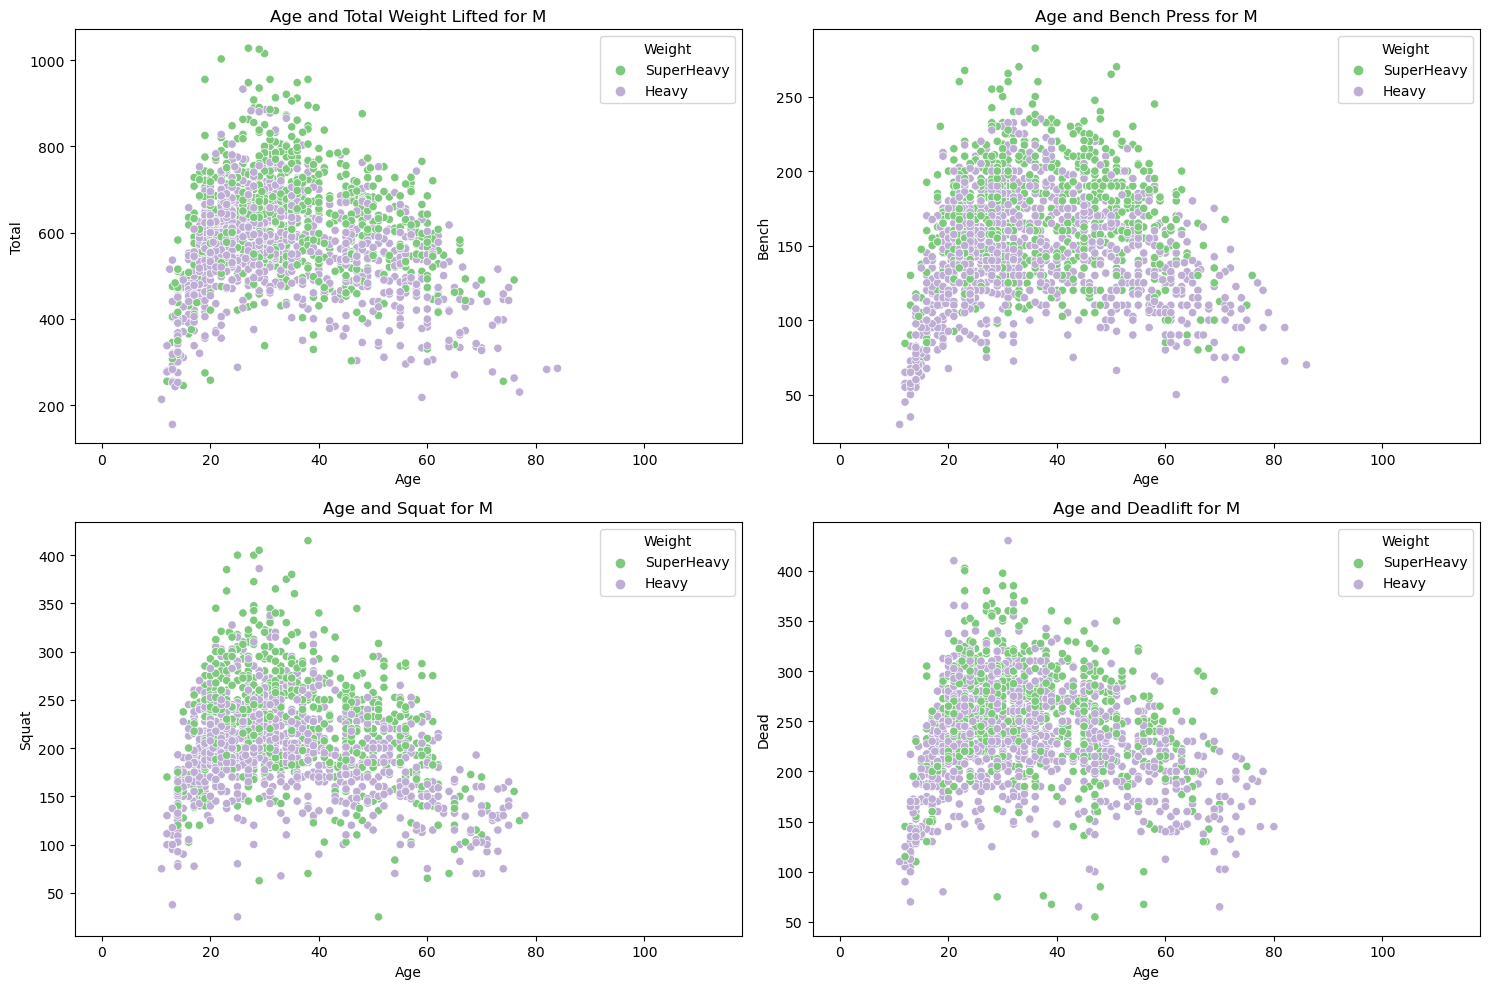

In [18]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Heavier')

Sex = F

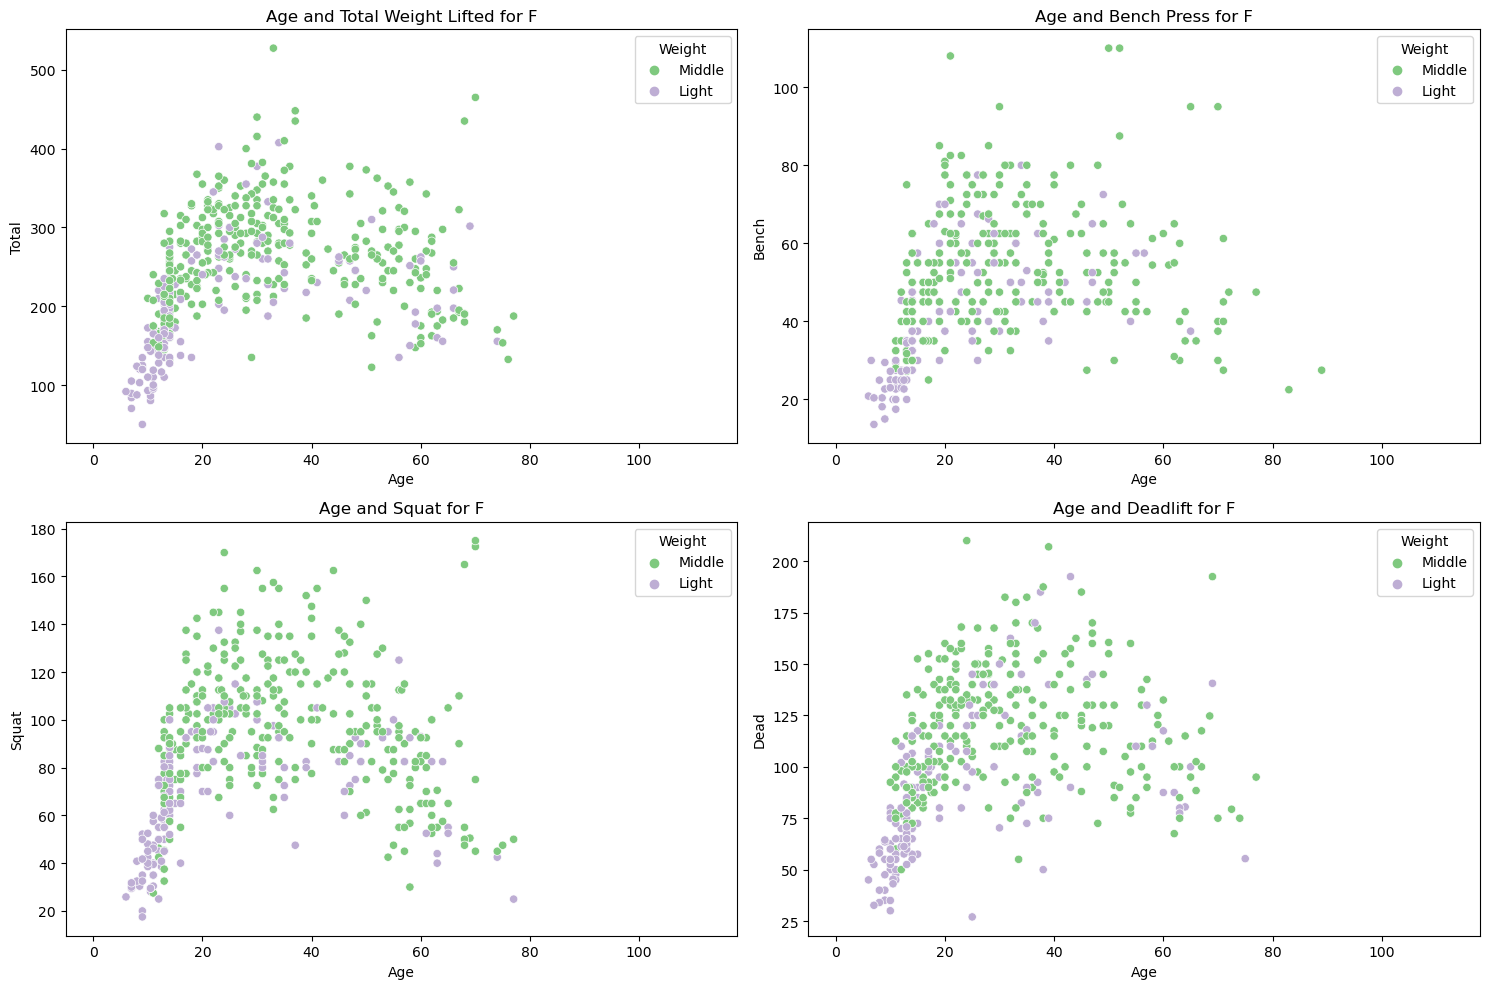

In [19]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Lighter')

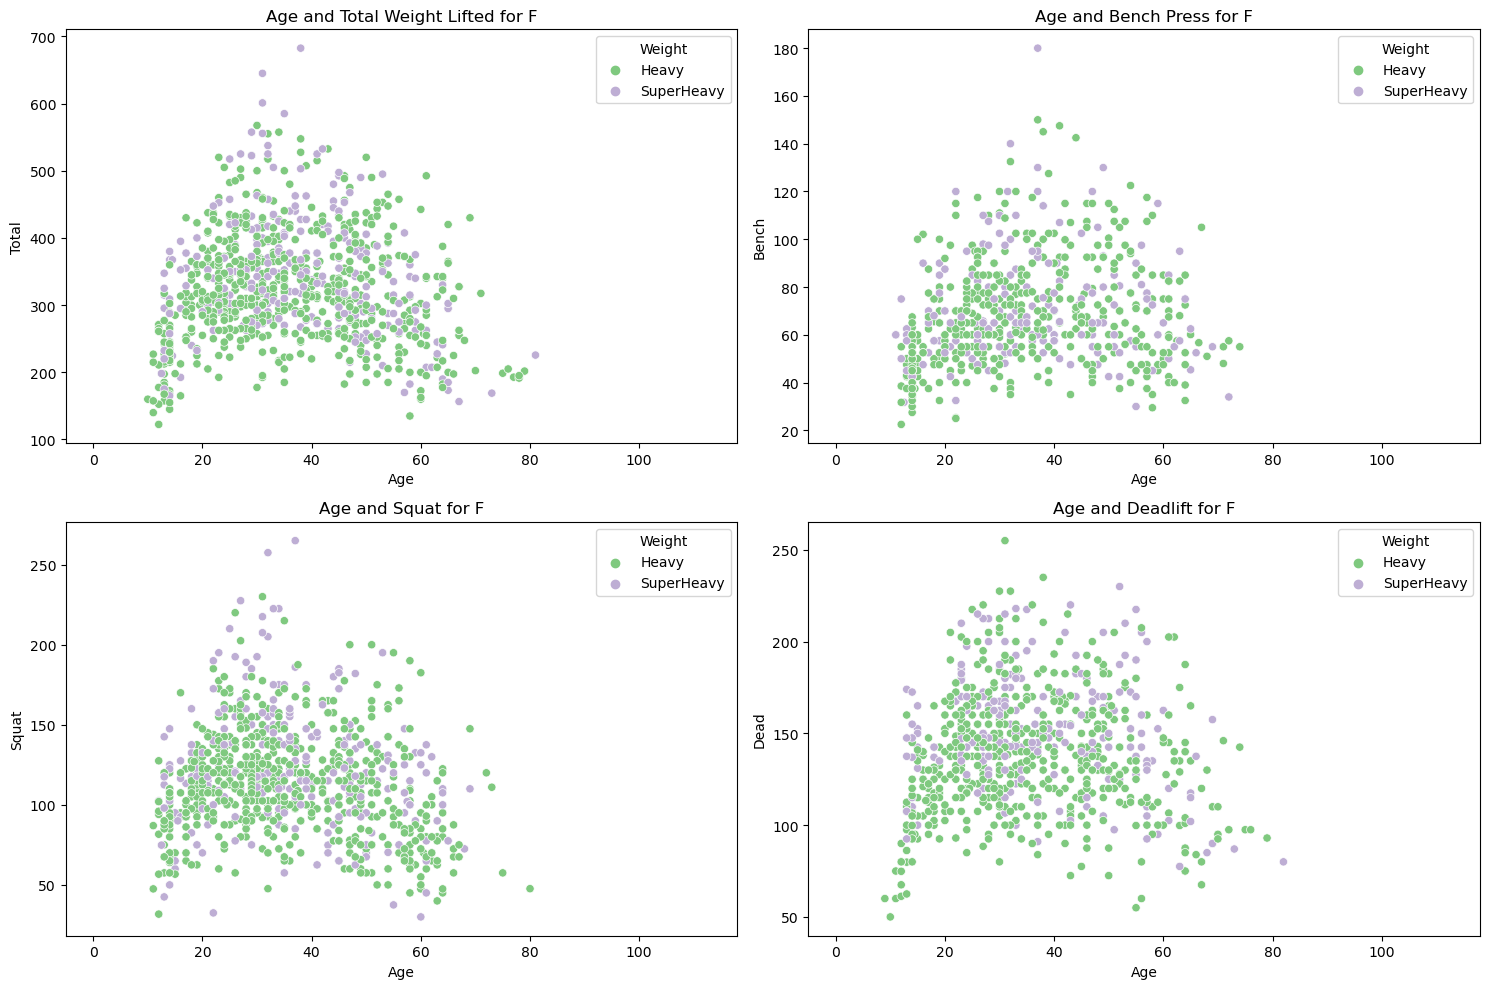

In [20]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Heavier')

# 1) Gaussian Distribution

Explore normality between Age Groups and Peak Strength levels across Total, Bench, Dead, and Squat

In [21]:
def max_strength(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('AgeGroup')[col].quantile(.9).reset_index().copy()
    return cutoff

def shapiro_wilk(total, sex, alpha):
    a = max_strength(total, sex)
    col = total.columns[3]
    stat, p = stats.shapiro(a[col])
    if p > alpha:
        return 'The data appears to be normally distributed (fail to reject H0)'
    else:
        return 'The data does not appear to be normally distributed (reject H0)'
        
def bar_quadrant(total, bench, squat, dead, sex):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    axs[0, 0].set_title('Top Total per Age Group for ' + sex)
    axs[0, 1].set_title('Top Bench Press per Age Group for ' + sex)
    axs[1, 0].set_title('Top Squat per Age Group for ' + sex)
    axs[1, 1].set_title('Top Deadlift per Age Group for ' + sex)

    sns.barplot(max_strength(total, sex), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
    sns.barplot(max_strength(bench, sex), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
    sns.barplot(max_strength(squat, sex), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
    sns.barplot(max_strength(dead, sex), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
    
    total_conclusion = shapiro_wilk(total, sex, alpha=0.05)
    bench_conclusion = shapiro_wilk(bench, sex, alpha=0.05)
    squat_conclusion = shapiro_wilk(squat, sex, alpha=0.05)
    dead_conclusion = shapiro_wilk(dead, sex, alpha=0.05)
    for ax in axs.flat:
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    round(bar.get_height(), 2), ha='center', va='bottom')
        
    axs[0, 0].text(0.5, -0.2, total_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 0].transAxes, fontsize=10, color='red')
    axs[0, 1].text(0.5, -0.2, bench_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 1].transAxes, fontsize=10, color='red')
    axs[1, 0].text(0.5, -0.2, squat_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 0].transAxes, fontsize=10, color='red')
    axs[1, 1].text(0.5, -0.2, dead_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 1].transAxes, fontsize=10, color='red')

    plt.tight_layout()


Null Hypothesis: The distribution of Top Strength per Age Group is normally distributed.

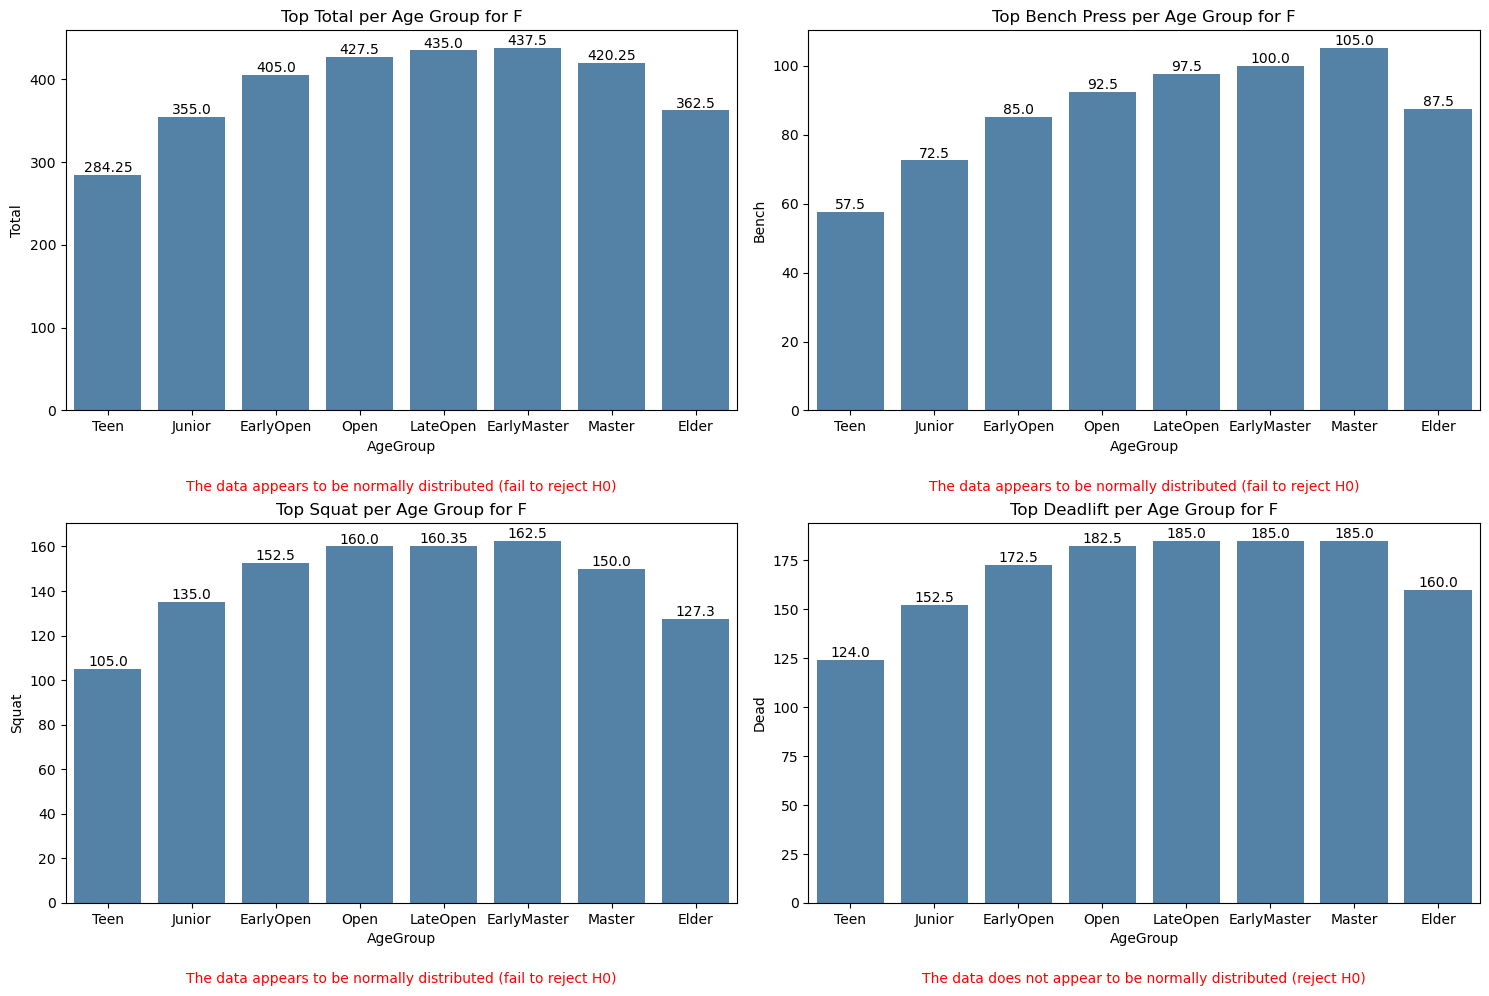

In [22]:
bar_quadrant(total,bench,squat,dead,'F')

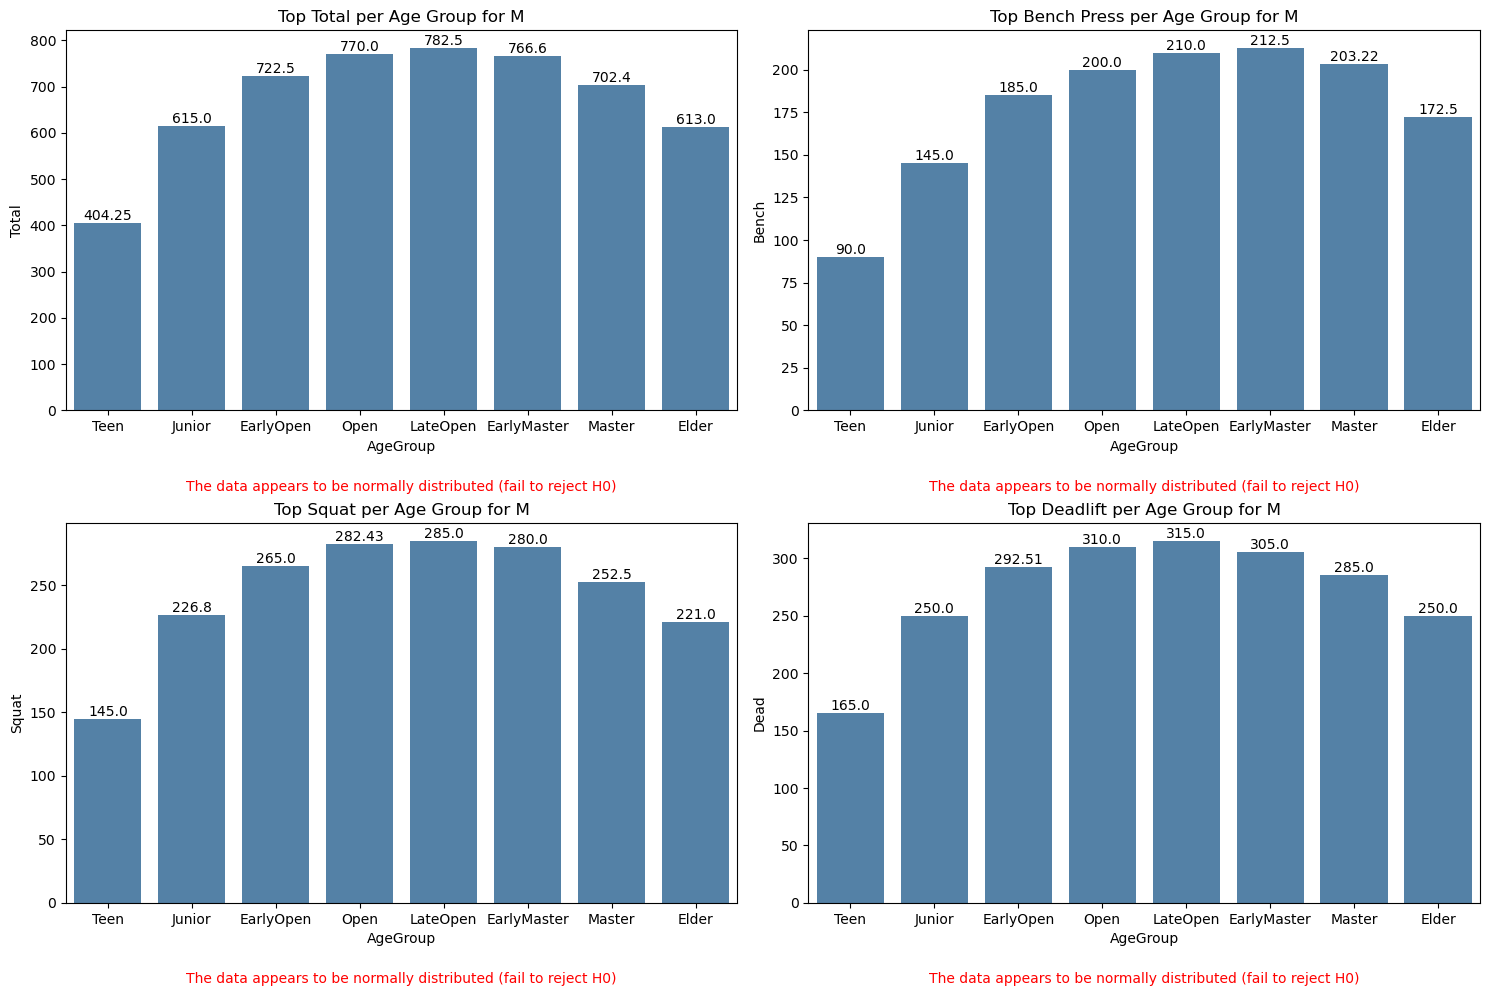

In [23]:
bar_quadrant(total,bench,squat,dead,'M')

# 2) Descriptive Statistical Testing

Top 10% of Total, Bench, Dead, and Squat for each Weight Group
- Statistical testing for difference in means in the top lifters per each weight class

In [24]:
def max_strength_df(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('Weight')[col].quantile(.9).reset_index().copy()
    for x in range(len(cutoff)):
        weight = cutoff.iloc[x,0]
        strength = cutoff.iloc[x,1]
        df = total[total['Sex'] == sex][(total[total['Sex'] == sex]['Weight']==weight)&(total[total['Sex'] == sex][col]>=strength)].copy()
        summary = pd.concat([summary, df], axis = 0, ignore_index = True)
    return summary

def mean_age_difference_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        for j in range(i + 1, len(weight_groups)):
            group1 = weight_groups[i]
            group2 = weight_groups[j]
            sample1 = df[(df['Weight'] == group1) & (df['Sex'] == sex)]['Age']
            sample2 = df[(df['Weight'] == group2) & (df['Sex'] == sex)]['Age']
            z_stat, p_value = ztest(sample1, sample2)

            p_value_formatted = '{:.5f}'.format(p_value) 
            
            if p_value < alpha:
                decision = 'Reject H0: There is a significant difference'
            else:
                decision = 'Fail to reject H0: There is no significant difference'
            
            results[f'{group1} vs {group2}'] = {'Z statistic': z_stat,
                                                 'p-value': p_value_formatted,
                                                 'Decision': decision}
    print(df.groupby('Weight')['Age'].describe())
    return results

def mean_weight_age_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    df = df[df['AgeGroup']!='Teen'] # low samples
    age_groups = df['AgeGroup'].unique()
    col = df.columns[3]
    top_age = df.groupby('AgeGroup')[col].mean().idxmax()
    age_groups = [x for x in age_groups if (x != top_age)]
    sample1 = df[(df['AgeGroup'] == top_age) & (df['Sex'] == sex)][col]
    for i in range(len(age_groups)):
        group2 = age_groups[i]
        sample2 = df[(df['AgeGroup'] == group2) & (df['Sex'] == sex)][col]
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'{top_age} vs {group2}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    print(df.groupby('AgeGroup')[col].describe())
    return results

Null hypothesis: The mean weight lifted, in peak lifters, of the strongest Age Group is not different than the other Age Groups

Total Weight Lifted

In [25]:
mean_weight_age_z_test(total, 'F', .05)

             count        mean        std    min     25%    50%      75%  \
AgeGroup                                                                   
Teen           0.0         NaN        NaN    NaN     NaN    NaN      NaN   
Junior        62.0  417.854839  53.539275  315.0  375.00  422.5  458.875   
EarlyOpen    506.0  438.189051  61.156971  315.0  391.00  437.5  470.000   
Open         779.0  450.280347  61.737596  315.0  420.00  450.0  487.500   
LateOpen     627.0  462.901866  65.648106  315.0  425.00  462.5  504.930   
EarlyMaster  757.0  466.948798  63.425637  315.0  430.91  462.5  505.000   
Master       254.0  453.349724  58.540426  315.5  425.00  453.0  488.250   
Elder         59.0  460.779661  25.011596  370.0  442.50  463.0  477.750   

               max  
AgeGroup            
Teen           NaN  
Junior       572.5  
EarlyOpen    692.5  
Open         677.5  
LateOpen     702.5  
EarlyMaster  735.0  
Master       645.0  
Elder        505.0  


{'EarlyMaster vs LateOpen': {'Z statistic': 1.1629783670854161,
  'p-value': '0.24484',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 5.923470179926601,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 5.219321446537725,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 8.010122719272296,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 3.013365056690976,
  'p-value': '0.00258',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 0.7422742467867693,
  'p-value': '0.45792',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [26]:
mean_weight_age_z_test(total, 'M', .05)

              count        mean         std    min      25%     50%     75%  \
AgeGroup                                                                      
Teen            0.0         NaN         NaN    NaN      NaN     NaN     NaN   
Junior        177.0  666.916554   92.901403  495.0  628.000  657.50  721.50   
EarlyOpen    1431.0  727.378484  100.062449  495.0  655.000  732.50  792.50   
Open         1918.0  766.137482  106.022033  495.0  705.125  757.50  837.50   
LateOpen     1340.0  779.682978   96.900210  495.0  722.500  774.19  847.50   
EarlyMaster  1088.0  778.384936   96.306789  495.0  722.500  777.50  847.50   
Master         90.0  746.477778   94.631853  500.0  680.625  735.75  826.25   
Elder          22.0  713.922727   40.630178  635.0  689.675  728.25  742.50   

                max  
AgeGroup             
Teen            NaN  
Junior        962.5  
EarlyOpen    1045.0  
Open         1101.0  
LateOpen     1127.5  
EarlyMaster  1077.5  
Master        915.0  
Elder      

{'LateOpen vs Open': {'Z statistic': 3.7164363150147315,
  'p-value': '0.00020',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyOpen': {'Z statistic': 13.962208688829092,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 0.32915299747505594,
  'p-value': '0.74204',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Master': {'Z statistic': 3.1514769188443066,
  'p-value': '0.00162',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Junior': {'Z statistic': 14.620090204386585,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Elder': {'Z statistic': 3.177570338311897,
  'p-value': '0.00149',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [27]:
mean_weight_age_z_test(squat, 'F', .05)

             count        mean        std    min     25%    50%      75%  \
AgeGroup                                                                   
Teen           0.0         NaN        NaN    NaN     NaN    NaN      NaN   
Junior        79.0  153.765823  22.089828  112.5  137.50  157.5  170.000   
EarlyOpen    600.0  163.017600  26.367523  112.5  142.50  160.0  178.125   
Open         814.0  168.179324  26.876485  112.5  150.00  167.5  185.000   
LateOpen     608.0  172.253109  28.050014  112.5  156.50  170.0  190.000   
EarlyMaster  723.0  173.985975  24.626945  112.5  160.00  170.5  187.500   
Master       203.0  170.480246  23.606100  115.0  158.75  167.5  187.500   
Elder         53.0  172.235849  15.854993  125.0  162.50  167.5  175.000   

               max  
AgeGroup            
Teen           NaN  
Junior       220.0  
EarlyOpen    265.0  
Open         267.5  
LateOpen     267.5  
EarlyMaster  272.5  
Master       240.0  
Elder        217.5  


{'EarlyMaster vs LateOpen': {'Z statistic': 1.1998771929136178,
  'p-value': '0.23019',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 6.995953930187959,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 4.396738040914216,
  'p-value': '0.00001',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 7.809878411461737,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 1.8082900968165279,
  'p-value': '0.07056',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 0.5095061417351688,
  'p-value': '0.61040',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [28]:
mean_weight_age_z_test(squat, 'M', .05)

              count        mean        std    min     25%    50%      75%  \
AgeGroup                                                                    
Teen            0.0         NaN        NaN    NaN     NaN    NaN      NaN   
Junior        276.0  239.605399  40.721396  175.0  222.50  235.0  263.560   
EarlyOpen    1664.0  265.185445  40.529875  175.0  232.50  265.0  290.000   
Open         1944.0  281.323225  44.426792  175.0  255.00  275.0  312.500   
LateOpen     1301.0  289.066972  42.315742  175.0  261.00  285.0  319.780   
EarlyMaster  1138.0  288.090668  42.064333  175.0  260.00  282.5  320.000   
Master        139.0  277.574029  40.648009  177.5  246.50  272.5  307.500   
Elder          22.0  260.861818  16.572353  230.0  252.11  262.5  273.125   

               max  
AgeGroup            
Teen           NaN  
Junior       410.0  
EarlyOpen    410.0  
Open         440.0  
LateOpen     465.0  
EarlyMaster  425.0  
Master       370.5  
Elder        285.0  


{'LateOpen vs Open': {'Z statistic': 4.9592443284378405,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyOpen': {'Z statistic': 15.616153454359052,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 0.5700204763607792,
  'p-value': '0.56866',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Junior': {'Z statistic': 17.75271498332832,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Master': {'Z statistic': 3.0549936329921334,
  'p-value': '0.00225',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Elder': {'Z statistic': 3.121324759061062,
  'p-value': '0.00180',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [29]:
mean_weight_age_z_test(bench, 'F', .05)

              count        mean        std   min       25%     50%     75%  \
AgeGroup                                                                     
Teen            0.0         NaN        NaN   NaN       NaN     NaN     NaN   
Junior         86.0   89.475930  17.527361  65.0   71.4825   88.75  102.06   
EarlyOpen     533.0   94.772964  17.859005  65.0   82.5000   92.50  105.00   
Open          767.0  100.617158  17.975276  65.0   85.0000  102.50  112.50   
LateOpen      836.0  105.613768  20.047514  65.0   90.0000  105.00  120.00   
EarlyMaster  1359.0  108.734040  21.167229  65.0   97.5000  107.50  120.00   
Master        739.0  107.170244  16.639705  65.0  100.0000  107.50  117.50   
Elder         189.0  102.665132  13.234097  65.0   95.0000  102.50  110.00   

               max  
AgeGroup            
Teen           NaN  
Junior       142.5  
EarlyOpen    165.0  
Open         157.5  
LateOpen     166.0  
EarlyMaster  180.0  
Master       170.0  
Elder        135.5  


{'EarlyMaster vs Master': {'Z statistic': 1.7374625391881369,
  'p-value': '0.08231',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 8.952954047578208,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 3.421460030099156,
  'p-value': '0.00062',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 13.462813073396836,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 3.8380664249470082,
  'p-value': '0.00012',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 8.259108608124286,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [30]:
mean_weight_age_z_test(bench, 'M', .05)

              count        mean        std    min    25%    50%       75%  \
AgeGroup                                                                    
Teen            0.0         NaN        NaN    NaN    NaN    NaN       NaN   
Junior        170.0  162.734353  35.278867  120.0  127.5  162.5  190.3825   
EarlyOpen    1505.0  188.594153  31.387416  120.0  165.0  192.5  207.5000   
Open         2959.0  201.241869  32.694116  120.0  180.0  200.0  225.0000   
LateOpen     2915.0  206.533067  31.451758  120.0  190.0  202.5  227.5000   
EarlyMaster  4054.0  209.071623  29.639263  120.0  190.0  210.0  230.0000   
Master       1202.0  204.434551  30.367168  120.0  182.5  202.5  227.5000   
Elder         159.0  203.623774  32.351304  120.0  190.0  200.0  230.0000   

                max  
AgeGroup             
Teen            NaN  
Junior       250.00  
EarlyOpen    288.03  
Open         325.00  
LateOpen     355.00  
EarlyMaster  335.00  
Master       290.00  
Elder        255.00  


{'EarlyMaster vs Master': {'Z statistic': 4.7368411657277765,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 22.52155135641227,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 10.45781122816708,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 3.437472003320897,
  'p-value': '0.00059',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 2.2654200550673624,
  'p-value': '0.02349',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 19.805000494093402,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Dead

In [31]:
mean_weight_age_z_test(dead, 'F', .05)

              count        mean        std     min    25%     50%      75%  \
AgeGroup                                                                     
Teen            0.0         NaN        NaN     NaN    NaN     NaN      NaN   
Junior         82.0  177.079268  19.287697  140.00  165.0  171.25  191.875   
EarlyOpen     657.0  185.013486  23.102295  140.00  167.5  185.00  197.500   
Open         1039.0  189.283022  23.809251  140.00  172.5  190.00  205.000   
LateOpen      948.0  193.529061  23.673375  140.00  182.5  192.50  207.500   
EarlyMaster  1239.0  197.144084  24.528291  140.00  182.5  195.00  210.000   
Master        464.0  194.480216  23.684267  140.00  182.5  194.00  207.500   
Elder         105.0  193.250286  13.832394  140.61  185.0  195.00  202.500   

               max  
AgeGroup            
Teen           NaN  
Junior       230.0  
EarlyOpen    282.5  
Open         275.0  
LateOpen     280.0  
EarlyMaster  290.0  
Master       280.0  
Elder        217.5  


{'EarlyMaster vs Open': {'Z statistic': 7.721085210944962,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 2.0140385058309707,
  'p-value': '0.04401',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 3.4673923966983917,
  'p-value': '0.00053',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 10.453828017195407,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 7.259540368859373,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 1.6048246095559202,
  'p-value': '0.10853',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [32]:
mean_weight_age_z_test(dead, 'M', .05)

              count        mean        std    min    25%    50%    75%     max
AgeGroup                                                                      
Teen            0.0         NaN        NaN    NaN    NaN    NaN    NaN     NaN
Junior        368.0  274.476087  39.375204  207.5  260.0  275.0  300.0  390.00
EarlyOpen    2181.0  298.498157  38.329416  207.5  272.5  300.0  325.0  432.50
Open         2831.0  311.672882  38.098423  207.5  290.0  312.5  335.0  487.50
LateOpen     2130.0  314.949441  34.594822  207.5  295.0  317.5  335.0  447.50
EarlyMaster  1680.0  313.569560  33.983377  207.5  295.0  320.0  335.0  421.00
Master        262.0  305.744542  29.984058  212.5  292.5  302.5  325.0  390.00
Elder          41.0  303.394634  23.956477  260.0  283.5  307.5  323.0  356.07


{'LateOpen vs EarlyOpen': {'Z statistic': 14.782755142684314,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 1.2319509822673629,
  'p-value': '0.21797',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Open': {'Z statistic': 3.1181217087482977,
  'p-value': '0.00182',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Master': {'Z statistic': 4.120493580205043,
  'p-value': '0.00004',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Junior': {'Z statistic': 20.288095052659738,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Elder': {'Z statistic': 2.128617863872251,
  'p-value': '0.03329',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in all Weight Groups of the same Sex are not different.

Total Weight Lifted

In [33]:
mean_age_difference_z_test(total,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2497.0  29.082099  6.398764  17.0  24.0  28.0  32.0  60.0
Light        301.0  26.099668  6.110922  15.0  22.0  25.0  29.0  54.0
Middle      1656.0  27.999094  6.652135  15.0  23.0  27.0  31.0  62.5
SuperHeavy  1612.0  30.901365  5.824738  18.0  27.0  30.0  35.0  48.0


{'Heavy vs Light': {'Z statistic': 7.675412073320091,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 5.256670064372192,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -9.21371027373957,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -4.612583323527473,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -13.026310752111895,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -13.255465936310594,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [34]:
mean_age_difference_z_test(total,'F',.05)

             count       mean        std   min   25%   50%   75%   max
Weight                                                                
Heavy       1519.0  32.855168   9.134846  15.0  26.0  31.0  38.0  69.0
Light        211.0  29.800948   7.960958  15.0  24.0  28.0  33.0  51.0
Middle       700.0  31.491429  10.006897  17.0  24.0  29.0  36.0  71.0
SuperHeavy   614.0  33.770358   7.759867  16.0  28.0  33.0  39.0  56.0


{'Heavy vs Light': {'Z statistic': 4.61888742146072,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 3.1695541097658917,
  'p-value': '0.00153',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -2.184252001706383,
  'p-value': '0.02894',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -2.2484650982264998,
  'p-value': '0.02455',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -6.367670176399152,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -4.565907585316759,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [35]:
mean_age_difference_z_test(squat,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2661.0  29.059752  6.849538  15.5  24.0  28.0  33.0  59.0
Light        331.0  25.019637  6.326980  15.0  21.0  24.0  28.0  54.0
Middle      1793.0  27.574735  6.905674  15.0  23.0  26.0  31.0  62.5
SuperHeavy  1699.0  30.764567  6.238432  17.0  26.0  30.0  35.0  53.0


{'Heavy vs Light': {'Z statistic': 10.203147362321479,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 7.072513955368146,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -8.295008667874496,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -6.263538812447,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -15.291993081374681,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -14.297700449865797,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [36]:
mean_age_difference_z_test(squat,'F',.05)

             count       mean        std   min   25%   50%   75%   max
Weight                                                                
Heavy       1506.0  31.970452   8.739338  15.0  26.0  30.0  38.0  61.0
Light        241.0  28.244813   6.718772  15.0  23.0  27.0  31.0  56.0
Middle       719.0  30.729485  10.084299  15.0  24.0  28.0  35.0  71.0
SuperHeavy   615.0  33.222764   7.927653  14.0  28.0  32.0  39.0  58.0


{'Heavy vs Light': {'Z statistic': 6.3250967674274285,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 2.9771934270100924,
  'p-value': '0.00291',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -3.0743626952120118,
  'p-value': '0.00211',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -3.568111835588789,
  'p-value': '0.00036',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -8.610457473777313,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -4.959146568386749,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [37]:
mean_age_difference_z_test(bench,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       5229.0  33.424460  8.076506  15.0  27.5  32.0  38.0  64.0
Light        637.0  28.571429  8.534014  15.0  23.0  27.0  33.0  62.0
Middle      3242.0  32.888186  8.642033  15.0  26.0  31.0  38.0  72.0
SuperHeavy  3856.0  35.294476  7.701220  17.0  29.0  35.0  40.0  62.0


{'Heavy vs Light': {'Z statistic': 14.228888096756318,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 2.891268918028197,
  'p-value': '0.00384',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -11.124193042943126,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -11.549011738760964,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -20.08986512924319,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -12.399235971460547,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [38]:
mean_age_difference_z_test(bench,'F',.05)

             count       mean        std   min    25%   50%   75%   max
Weight                                                                 
Heavy       2118.0  36.985836  10.415235  15.0  29.00  36.0  44.0  69.0
Light        415.0  31.195181   9.468571  13.0  23.75  29.0  37.0  63.0
Middle      1145.0  34.387336  10.818551  14.0  26.00  32.0  40.0  71.0
SuperHeavy   836.0  37.077751   8.818187  16.0  30.00  37.0  42.0  61.0


{'Heavy vs Light': {'Z statistic': 10.507044878950454,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 6.709319743526016,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -0.22527298603199747,
  'p-value': '0.82177',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs Middle': {'Z statistic': -5.317645771826591,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -10.837959972123935,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -5.900249940598015,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Deadlift

In [39]:
mean_age_difference_z_test(dead,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       3788.0  29.439546  7.003586  16.0  24.0  28.0  33.0  64.0
Light        552.0  25.617754  6.497151  15.0  21.0  24.0  29.0  54.0
Middle      2597.0  28.300924  7.182925  15.0  23.0  27.0  32.0  66.0
SuperHeavy  2556.0  31.260955  6.400891  18.0  27.0  30.0  35.0  57.0


{'Heavy vs Light': {'Z statistic': 12.085242893605718,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 6.315189391540904,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -10.51477040220431,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -8.10012526216023,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -18.733992480856234,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -15.608958844570855,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [40]:
mean_age_difference_z_test(dead,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2244.0  33.939840  9.175237  15.0  27.0  32.0  39.0  67.0
Light        379.0  30.622691  8.182047  17.0  24.0  29.0  36.0  69.0
Middle      1065.0  32.068545  9.897263  15.0  25.0  30.0  37.0  71.0
SuperHeavy   846.0  35.306147  8.495158  16.0  29.0  34.0  41.0  62.0


{'Heavy vs Light': {'Z statistic': 6.60828958126414,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 5.342259040304882,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -3.765309034689544,
  'p-value': '0.00017',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -2.5505367500451093,
  'p-value': '0.01076',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -9.020757892650204,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -7.556874819033849,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in each Weight Group are the same across Sex.

In [41]:
def mean_age_difference_z_test_2(total, alpha):
    results = {}
    df1 = max_strength_df(total, 'M')
    df2 = max_strength_df(total,'F')
    
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        weight = weight_groups[i]
        sample1 = df1[df1['Weight']==weight]['Age'].copy()
        sample2 = df2[df2['Weight']==weight]['Age'].copy()
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'F v M in {weight}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    dfs = pd.concat([df2.groupby('Weight')['Age'].mean(),
           df1.groupby('Weight')['Age'].mean()], axis = 1)
    dfs['Delta'] = dfs.iloc[:,0]-dfs.iloc[:,1]
    dfs.columns = ['F mean age','M mean age', 'Delta']
    print(dfs)
    return results

In [42]:
mean_age_difference_z_test_2(total,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        32.855168   29.082099  3.773069
Light        29.800948   26.099668  3.701280
Middle       31.491429   27.999094  3.492334
SuperHeavy   33.770358   30.901365  2.868994


{'F v M in Heavy': {'Z statistic': -15.356186337813487,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -9.428135449167783,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Middle': {'Z statistic': -9.930955167467408,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -5.946149629335805,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [43]:
mean_age_difference_z_test_2(squat,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        31.970452   29.059752  2.910700
Light        28.244813   25.019637  3.225176
Middle       30.729485   27.574735  3.154750
SuperHeavy   33.222764   30.764567  2.458197


{'F v M in Heavy': {'Z statistic': -11.897484475225545,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -7.7633526407583835,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Middle': {'Z statistic': -8.994330066527196,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -5.864221361281404,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [44]:
mean_age_difference_z_test_2(bench,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        36.985836   33.424460  3.561376
Light        31.195181   28.571429  2.623752
Middle       34.387336   32.888186  1.499150
SuperHeavy   37.077751   35.294476  1.783275


{'F v M in Heavy': {'Z statistic': -15.686973046462992,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -5.9080618334181025,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Middle': {'Z statistic': -4.709678984560319,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -4.665799999329609,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [45]:
mean_age_difference_z_test_2(dead,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        33.939840   29.439546  4.500294
Light        30.622691   25.617754  5.004938
Middle       32.068545   28.300924  3.767620
SuperHeavy   35.306147   31.260955  4.045192


{'F v M in Heavy': {'Z statistic': -21.43447942292267,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -14.61044455347132,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Middle': {'Z statistic': -12.8357477133258,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -10.376708696182018,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

# 3) Peak Age Linear Regression Testing

Exploring the relationship leading up to and after the Peak Age per Weight Group for top strength levels

In [46]:
def pre_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]

    a['high'] = a['mean']-a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        high = a.iloc[x,2]
        high_df = aa[(aa['Weight']== a.index[x])&(aa['Age']<=high)].copy()
        high_r = stats.linregress(high_df['Age'],high_df[col])
        results[f'{col} and Age Pre-Peak Age for {weight} {sex}'] = {'Peak-Age':round(high,2),
                                                                     'Slope':round(stats.linregress(high_df['Age'],high_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(high_df['Age'],high_df[col])[3]),
                                                                'R':round(stats.linregress(high_df['Age'],high_df[col])[2],2)}
    return results

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters leading up to Peak Age

Sex: M

In [47]:
pre_peak_lin(total,'M')

{'Total and Age Pre-Peak Age for Heavy M': {'Peak-Age': 22.68,
  'Slope': 7.76,
  'p-value': '0.00013',
  'R': 0.22},
 'Total and Age Pre-Peak Age for Light M': {'Peak-Age': 19.99,
  'Slope': 5.22,
  'p-value': '0.18633',
  'R': 0.25},
 'Total and Age Pre-Peak Age for Middle M': {'Peak-Age': 21.35,
  'Slope': -0.03,
  'p-value': '0.98689',
  'R': -0.0},
 'Total and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 25.08,
  'Slope': 2.62,
  'p-value': '0.20831',
  'R': 0.07}}

In [48]:
pre_peak_lin(squat,'M')

{'Squat and Age Pre-Peak Age for Heavy M': {'Peak-Age': 22.21,
  'Slope': 2.55,
  'p-value': '0.00007',
  'R': 0.2},
 'Squat and Age Pre-Peak Age for Light M': {'Peak-Age': 18.69,
  'Slope': 1.44,
  'p-value': '0.26664',
  'R': 0.18},
 'Squat and Age Pre-Peak Age for Middle M': {'Peak-Age': 20.67,
  'Slope': 0.07,
  'p-value': '0.93669',
  'R': 0.01},
 'Squat and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 24.53,
  'Slope': -0.2,
  'p-value': '0.80329',
  'R': -0.01}}

In [49]:
pre_peak_lin(bench,'M')

{'Bench and Age Pre-Peak Age for Heavy M': {'Peak-Age': 25.35,
  'Slope': 0.04,
  'p-value': '0.87618',
  'R': 0.01},
 'Bench and Age Pre-Peak Age for Light M': {'Peak-Age': 20.04,
  'Slope': 0.48,
  'p-value': '0.42415',
  'R': 0.09},
 'Bench and Age Pre-Peak Age for Middle M': {'Peak-Age': 24.25,
  'Slope': 1.19,
  'p-value': '0.00018',
  'R': 0.16},
 'Bench and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 27.59,
  'Slope': 1.02,
  'p-value': '0.00062',
  'R': 0.14}}

In [50]:
pre_peak_lin(dead,'M')

{'Dead and Age Pre-Peak Age for Heavy M': {'Peak-Age': 22.44,
  'Slope': 1.86,
  'p-value': '0.00326',
  'R': 0.13},
 'Dead and Age Pre-Peak Age for Light M': {'Peak-Age': 19.12,
  'Slope': -0.03,
  'p-value': '0.97742',
  'R': -0.0},
 'Dead and Age Pre-Peak Age for Middle M': {'Peak-Age': 21.12,
  'Slope': 0.47,
  'p-value': '0.42884',
  'R': 0.04},
 'Dead and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 24.86,
  'Slope': 1.53,
  'p-value': '0.05588',
  'R': 0.1}}

Sex: F

In [51]:
pre_peak_lin(total,'F')

{'Total and Age Pre-Peak Age for Heavy F': {'Peak-Age': 23.72,
  'Slope': 5.22,
  'p-value': '0.00101',
  'R': 0.22},
 'Total and Age Pre-Peak Age for Light F': {'Peak-Age': 21.84,
  'Slope': 11.74,
  'p-value': '0.01233',
  'R': 0.56},
 'Total and Age Pre-Peak Age for Middle F': {'Peak-Age': 21.48,
  'Slope': 5.12,
  'p-value': '0.12363',
  'R': 0.18},
 'Total and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 26.01,
  'Slope': -3.75,
  'p-value': '0.02834',
  'R': -0.21}}

In [52]:
pre_peak_lin(squat,'F')

{'Squat and Age Pre-Peak Age for Heavy F': {'Peak-Age': 23.23,
  'Slope': 1.57,
  'p-value': '0.00589',
  'R': 0.17},
 'Squat and Age Pre-Peak Age for Light F': {'Peak-Age': 21.53,
  'Slope': 1.62,
  'p-value': '0.16511',
  'R': 0.3},
 'Squat and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.65,
  'Slope': 2.47,
  'p-value': '0.01876',
  'R': 0.29},
 'Squat and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 25.3,
  'Slope': -1.06,
  'p-value': '0.16838',
  'R': -0.14}}

In [53]:
pre_peak_lin(bench,'F')

{'Bench and Age Pre-Peak Age for Heavy F': {'Peak-Age': 26.57,
  'Slope': 0.55,
  'p-value': '0.01624',
  'R': 0.13},
 'Bench and Age Pre-Peak Age for Light F': {'Peak-Age': 21.73,
  'Slope': 1.6,
  'p-value': '0.00635',
  'R': 0.38},
 'Bench and Age Pre-Peak Age for Middle F': {'Peak-Age': 23.57,
  'Slope': -0.33,
  'p-value': '0.32241',
  'R': -0.07},
 'Bench and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 28.26,
  'Slope': 0.02,
  'p-value': '0.95558',
  'R': 0.0}}

In [54]:
pre_peak_lin(dead,'F')

{'Dead and Age Pre-Peak Age for Heavy F': {'Peak-Age': 24.76,
  'Slope': 0.48,
  'p-value': '0.31442',
  'R': 0.06},
 'Dead and Age Pre-Peak Age for Light F': {'Peak-Age': 22.44,
  'Slope': 1.72,
  'p-value': '0.25634',
  'R': 0.16},
 'Dead and Age Pre-Peak Age for Middle F': {'Peak-Age': 22.17,
  'Slope': 1.56,
  'p-value': '0.00198',
  'R': 0.26},
 'Dead and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 26.81,
  'Slope': 0.18,
  'p-value': '0.78702',
  'R': 0.03}}

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters after to Peak Age

In [55]:
def post_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]
    a['low'] = a['mean']+a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        low = a.iloc[x,2]
        low_df = aa[(aa['Weight']== a.index[x])&(aa['Age']>=low)].copy()
        low_r = stats.linregress(low_df['Age'],low_df[col])
        results[f'{col} and Age Post-Peak Age for {weight} {sex}'] = {'Peak-Age':round(low,2),
                                                                      'Slope':round(stats.linregress(low_df['Age'],low_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(low_df['Age'],low_df[col])[3]),
                                                                'R':round(stats.linregress(low_df['Age'],low_df[col])[2],2)}
    return results

Sex: M

In [56]:
post_peak_lin(total,'M')

{'Total and Age Post-Peak Age for Heavy M': {'Peak-Age': 35.48,
  'Slope': -0.97,
  'p-value': '0.02642',
  'R': -0.11},
 'Total and Age Post-Peak Age for Light M': {'Peak-Age': 32.21,
  'Slope': -1.46,
  'p-value': '0.48173',
  'R': -0.11},
 'Total and Age Post-Peak Age for Middle M': {'Peak-Age': 34.65,
  'Slope': -0.5,
  'p-value': '0.30906',
  'R': -0.06},
 'Total and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 36.73,
  'Slope': -0.81,
  'p-value': '0.34243',
  'R': -0.05}}

In [57]:
post_peak_lin(squat,'M')

{'Squat and Age Post-Peak Age for Heavy M': {'Peak-Age': 35.91,
  'Slope': -0.58,
  'p-value': '0.00053',
  'R': -0.17},
 'Squat and Age Post-Peak Age for Light M': {'Peak-Age': 31.35,
  'Slope': -0.09,
  'p-value': '0.91373',
  'R': -0.02},
 'Squat and Age Post-Peak Age for Middle M': {'Peak-Age': 34.48,
  'Slope': -0.46,
  'p-value': '0.03040',
  'R': -0.13},
 'Squat and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 37.0,
  'Slope': -0.1,
  'p-value': '0.79664',
  'R': -0.02}}

In [58]:
post_peak_lin(bench,'M')

{'Bench and Age Post-Peak Age for Heavy M': {'Peak-Age': 41.5,
  'Slope': -0.07,
  'p-value': '0.46211',
  'R': -0.03},
 'Bench and Age Post-Peak Age for Light M': {'Peak-Age': 37.11,
  'Slope': -0.45,
  'p-value': '0.02502',
  'R': -0.23},
 'Bench and Age Post-Peak Age for Middle M': {'Peak-Age': 41.53,
  'Slope': -0.43,
  'p-value': '0.00161',
  'R': -0.13},
 'Bench and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 43.0,
  'Slope': 0.71,
  'p-value': '0.00000',
  'R': 0.2}}

In [59]:
post_peak_lin(dead,'M')

{'Dead and Age Post-Peak Age for Heavy M': {'Peak-Age': 36.44,
  'Slope': -0.35,
  'p-value': '0.00850',
  'R': -0.11},
 'Dead and Age Post-Peak Age for Light M': {'Peak-Age': 32.11,
  'Slope': -0.68,
  'p-value': '0.22221',
  'R': -0.14},
 'Dead and Age Post-Peak Age for Middle M': {'Peak-Age': 35.48,
  'Slope': -0.18,
  'p-value': '0.17115',
  'R': -0.07},
 'Dead and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 37.66,
  'Slope': -0.27,
  'p-value': '0.20695',
  'R': -0.06}}

Sex: F

In [60]:
post_peak_lin(total,'F')

{'Total and Age Post-Peak Age for Heavy F': {'Peak-Age': 41.99,
  'Slope': -1.14,
  'p-value': '0.00388',
  'R': -0.18},
 'Total and Age Post-Peak Age for Light F': {'Peak-Age': 37.76,
  'Slope': -3.26,
  'p-value': '0.07183',
  'R': -0.28},
 'Total and Age Post-Peak Age for Middle F': {'Peak-Age': 41.5,
  'Slope': 1.87,
  'p-value': '0.00001',
  'R': 0.5},
 'Total and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 41.53,
  'Slope': -0.8,
  'p-value': '0.45839',
  'R': -0.07}}

In [61]:
post_peak_lin(squat,'F')

{'Squat and Age Post-Peak Age for Heavy F': {'Peak-Age': 40.71,
  'Slope': -0.14,
  'p-value': '0.43317',
  'R': -0.05},
 'Squat and Age Post-Peak Age for Light F': {'Peak-Age': 34.96,
  'Slope': -0.02,
  'p-value': '0.97267',
  'R': -0.01},
 'Squat and Age Post-Peak Age for Middle F': {'Peak-Age': 40.81,
  'Slope': 0.58,
  'p-value': '0.00001',
  'R': 0.45},
 'Squat and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 41.15,
  'Slope': 0.09,
  'p-value': '0.84097',
  'R': 0.02}}

In [62]:
post_peak_lin(bench,'F')

{'Bench and Age Post-Peak Age for Heavy F': {'Peak-Age': 47.4,
  'Slope': -0.18,
  'p-value': '0.07514',
  'R': -0.09},
 'Bench and Age Post-Peak Age for Light F': {'Peak-Age': 40.66,
  'Slope': -0.12,
  'p-value': '0.49497',
  'R': -0.08},
 'Bench and Age Post-Peak Age for Middle F': {'Peak-Age': 45.21,
  'Slope': -0.3,
  'p-value': '0.01838',
  'R': -0.17},
 'Bench and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 45.9,
  'Slope': -0.2,
  'p-value': '0.43495',
  'R': -0.07}}

In [63]:
post_peak_lin(dead,'F')

{'Dead and Age Post-Peak Age for Heavy F': {'Peak-Age': 43.12,
  'Slope': -0.22,
  'p-value': '0.05896',
  'R': -0.1},
 'Dead and Age Post-Peak Age for Light F': {'Peak-Age': 38.8,
  'Slope': -0.44,
  'p-value': '0.20145',
  'R': -0.16},
 'Dead and Age Post-Peak Age for Middle F': {'Peak-Age': 41.97,
  'Slope': 0.7,
  'p-value': '0.00000',
  'R': 0.37},
 'Dead and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 43.8,
  'Slope': -1.31,
  'p-value': '0.00075',
  'R': -0.27}}

# 4) Peak Age Polynomial Regression Testing

In [64]:
def pord(total, sex, deg):
    col = total.columns[3]
    a = total[total['Sex'] == sex].groupby('Age')[col].mean().reset_index().copy()
    X = a['Age']
    Y = a[col]
    poly_model = odr.polynomial(deg)
    data = odr.Data(X, Y)

    odr_obj = odr.ODR(data, poly_model)
    output = odr_obj.run()

    poly = np.poly1d(output.beta[::-1])
    poly_y = poly(X)
    plt.plot(X, Y, label='Weight Lifted')
    plt.plot(X, poly_y, label='Polynomial ODR')
    plt.xlabel('Age')
    plt.ylabel('Weight Lifted')
    plt.legend()
    print('Peak Mean Weight Lifted is at: '+str(X[poly_y.argmax()])+' years old.')
    degf = len(X)-2
    beta_0 = 0
    stat = (output.beta[0] - beta_0) / output.sd_beta[0]
    p_val = stats.t.sf(np.abs(stat), degf) * 2
    print('Recovered equation: y={:3.2f}x + {:3.2f}, t={:3.2f}, p={:.2e}'.format(output.beta[0], output.beta[1], stat, p_val))
    print('R_Squared: '+str(1 - (np.var((Y - poly_y)) / np.var(Y))))

Total Weight Lifted

Peak Mean Weight Lifted is at: 35.5 years old.
Recovered equation: y=-49.75x + 27.55, t=-1.08, p=2.84e-01
R_Squared: 0.7488272475397849


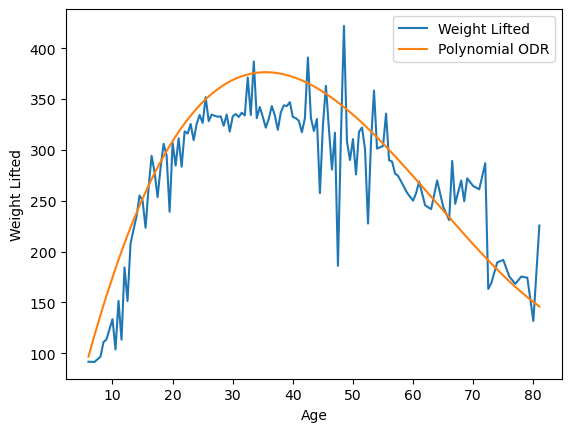

In [65]:
pord(total,'F',3)

Peak Mean Weight Lifted is at: 33.5 years old.
Recovered equation: y=-318.63x + 75.83, t=-2.90, p=4.33e-03
R_Squared: 0.729866871979499


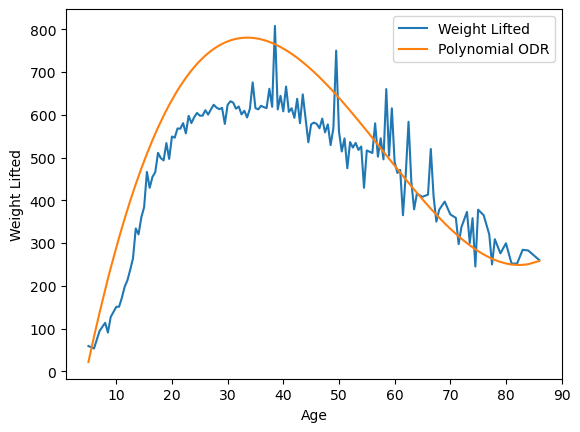

In [66]:
pord(total,'M',3)

Squat

Peak Mean Weight Lifted is at: 35.5 years old.
Recovered equation: y=-34.68x + 10.55, t=-2.14, p=3.42e-02
R_Squared: 0.8100350741556958


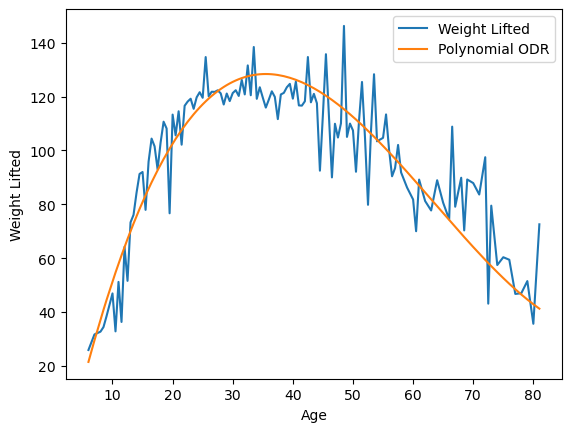

In [67]:
pord(squat,'F',3)

Peak Mean Weight Lifted is at: 35.0 years old.
Recovered equation: y=-84.79x + 22.08, t=-2.67, p=8.39e-03
R_Squared: 0.8396641383155456


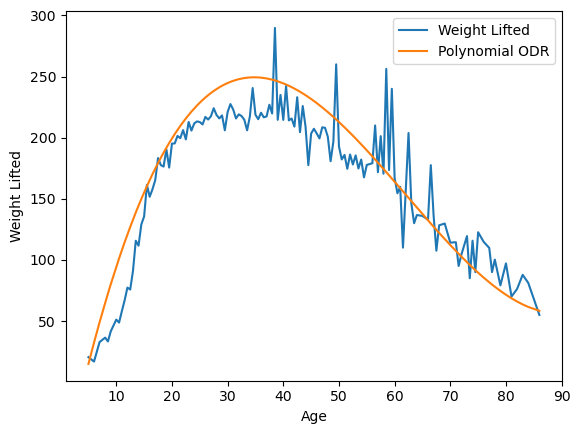

In [68]:
pord(squat,'M',3)

Bench

Peak Mean Weight Lifted is at: 39.0 years old.
Recovered equation: y=-16.87x + 5.43, t=-2.07, p=3.97e-02
R_Squared: 0.8289333083462771


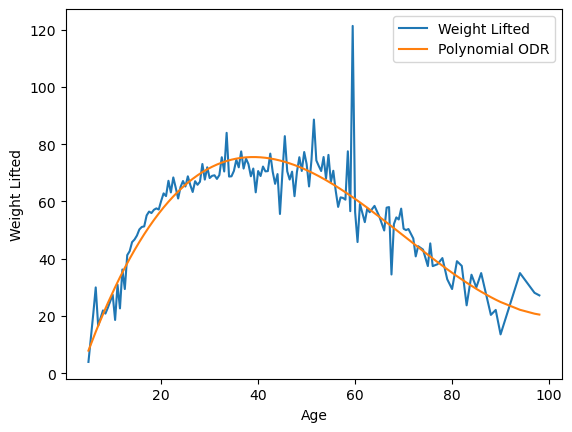

In [69]:
pord(bench,'F',3)

Peak Mean Weight Lifted is at: 40.0 years old.
Recovered equation: y=-46.32x + 12.41, t=-4.42, p=1.77e-05
R_Squared: 0.9317378138428634


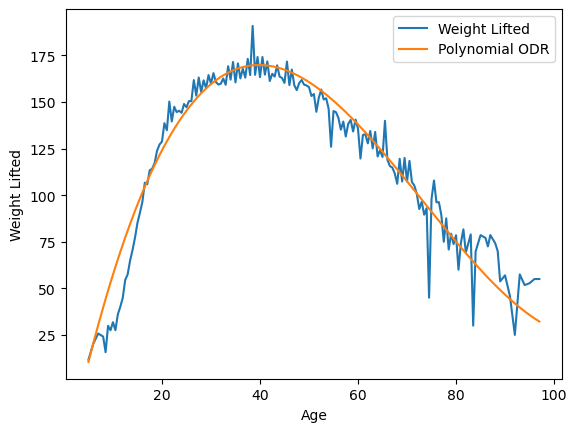

In [70]:
pord(bench,'M',3)

Deadlift

Peak Mean Weight Lifted is at: 38.0 years old.
Recovered equation: y=-11.03x + 9.74, t=-0.93, p=3.51e-01
R_Squared: 0.8750251402861675


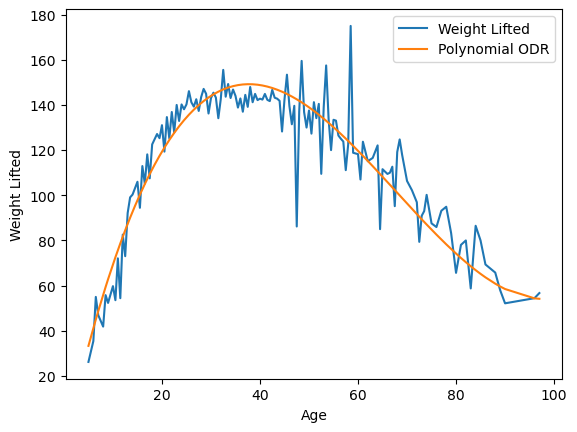

In [71]:
pord(dead,'F',3)

Peak Mean Weight Lifted is at: 37.5 years old.
Recovered equation: y=-60.85x + 19.33, t=-2.54, p=1.20e-02
R_Squared: 0.8790735398108449


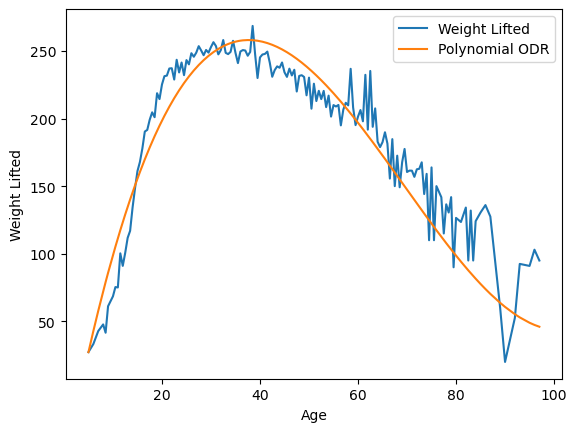

In [72]:
pord(dead,'M',3)

# Export Drug Tested Top Strength Population

Export the dataframe consisting of top 10% strength for each weight group

In [73]:
max_strength_df(total,'M').to_pickle('NDT_Total_M.pkl')
max_strength_df(squat,'M').to_pickle('NDT_Squat_M.pkl')
max_strength_df(bench,'M').to_pickle('NDT_Bench_M.pkl')
max_strength_df(dead,'M').to_pickle('NDT_Dead_M.pkl')

max_strength_df(total,'F').to_pickle('NDT_Total_F.pkl')
max_strength_df(squat,'F').to_pickle('NDT_Squat_F.pkl')
max_strength_df(bench,'F').to_pickle('NDT_Bench_F.pkl')
max_strength_df(dead,'F').to_pickle('NDT_Dead_F.pkl')